In [76]:
%pip install pandas numpy pyyaml darts 

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import darts
from darts import TimeSeries
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer, MissingValuesFiller, InvertibleMapper
import sklearn
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from tqdm import tqdm
from datetime import datetime, timedelta
from darts.models.forecasting.lgbm import LightGBMModel
from darts.models.forecasting.linear_regression_model import LinearRegressionModel
from lightgbm import early_stopping
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import matplotlib.pyplot as plt
from darts.metrics import rmsle


plt.style.use("ggplot")
plt.rcParams["font.size"] = 15
COLORS = list(sns.color_palette())

Reading all the CSVs and creating dataframes out of them

In [2]:
df_train = pd.read_csv('../Favorita-store-sales-prediction/Data/train.csv', parse_dates=["date"])
df_test = pd.read_csv('../Favorita-store-sales-prediction/Data/test.csv', parse_dates=["date"])
df_holidays = pd.read_csv('../Favorita-store-sales-prediction/Data/holidays_events.csv', parse_dates=["date"])
df_oil = pd.read_csv('../Favorita-store-sales-prediction/Data/oil.csv', parse_dates=["date"]).rename(columns={"dcoilwtico": "oil"})
df_stores = pd.read_csv('../Favorita-store-sales-prediction/Data/stores.csv')
df_transactions = pd.read_csv('../Favorita-store-sales-prediction/Data/transactions.csv', parse_dates=["date"])
df_sample_submission = pd.read_csv('../Favorita-store-sales-prediction/Data/sample_submission.csv')

# Data Preprocessing

In this problem, our target series for forecasting is the sales column for the Ecuadorian-based grocery retailer. With 54 stores present, each having 33 types of products sold, this amounts to 1782 target series for forecasting. We can check that there are missing gaps (4 missing dates) in our target series, which we will investigate next.

In [3]:
num_family = df_train.family.nunique()
num_store = df_train.store_nbr.nunique()
num_ts = df_train.groupby(["store_nbr", "family"]).ngroups
train_start = df_train.date.min().date()
train_end = df_train.date.max().date()
num_train_date = df_train.date.nunique()
train_len = (train_end - train_start).days + 1
test_start = df_test.date.min().date()
test_end = df_test.date.max().date()
num_test_date = df_test.date.nunique()
test_len = (test_end - test_start).days + 1


##### Basic Information about the data

In [4]:
print("Basic information of data\n",
    f"Number of family types      : {num_family}\n",
    f"Number of stores            : {num_store}\n",
    f"Number of store-family pairs: {num_family * num_store}\n",
    f"Number of target series     : {num_ts}\n",
    f"Number of unique train dates: {num_train_date}\n",
    f"Train date range            : {train_len} days from {train_start} to {train_end}\n",
    f"Number of unique test dates : {num_test_date}\n",
    f"Test date range             : {test_len} days from {test_start} to {test_end}\n")

Basic information of data
 Number of family types      : 33
 Number of stores            : 54
 Number of store-family pairs: 1782
 Number of target series     : 1782
 Number of unique train dates: 1684
 Train date range            : 1688 days from 2013-01-01 to 2017-08-15
 Number of unique test dates : 16
 Test date range             : 16 days from 2017-08-16 to 2017-08-31



#### Missing Data
1) Four missing dates fall on Christmas across the years.
It turns out that all the target series have missing dates on Christmas across the years, which suggests that the stores could be closed on this day.

In [5]:
missing_dates = pd.date_range(train_start, train_end).difference(df_train.date.unique())
missing_dates = missing_dates.strftime("%Y-%m-%d").tolist()

unique_dp_count = df_train.groupby(["store_nbr", "family"]).date.count().unique().tolist()

In [6]:
print("Missing gaps in time series\n",
    f"List incl. unique counts of data points: {unique_dp_count}\n",
    f"Missing dates                          : {missing_dates}\n",)

Missing gaps in time series
 List incl. unique counts of data points: [1684]
 Missing dates                          : ['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25']



we will fill the missing dates by reindexing our training data, and then fill the sales and onpromotion columns with 0s to indicate that there are no sales/promotions since the stores are closed.

In [7]:
multi_idx = pd.MultiIndex.from_product(
    [pd.date_range(train_start, train_end), df_train.store_nbr.unique(), df_train.family.unique()],
    names=["date", "store_nbr", "family"],
)
df_train = df_train.set_index(["date", "store_nbr", "family"]).reindex(multi_idx).reset_index()

# fill missing values with 0s
df_train[["sales", "onpromotion"]] = df_train[["sales", "onpromotion"]].fillna(0.)
df_train.id = df_train.id.interpolate(method="linear") # interpolate linearly as a filler for the 'id'

2. We can check there there are no oil prices on weekends, and this is mainly due to the nature of trading markets.

In [8]:
missing_oil_dates = pd.date_range(train_start, test_end).difference(df_oil.date)
num_missing_oil_dates = len(missing_oil_dates)
num_wknd_missing = (missing_oil_dates.weekday >= 5).sum()
total_num_wknd = (pd.date_range(train_start, test_end).weekday >= 5).sum()

In [9]:
print("Missing oil dates\n",
    f"Number of missing oil dates: {num_missing_oil_dates}\n",
    f"Number of weekends missing : {num_wknd_missing}\n",
    f"Total number of weekends   : {total_num_wknd}\n",)

Missing oil dates
 Number of missing oil dates: 486
 Number of weekends missing : 486
 Total number of weekends   : 486



Because our grocery stores open on weekends as well, there is a need to estimate the missing oil prices if we are to use them in our models. For simplicity, we fill the missing values in the oil column using linear interpolation.

In [10]:
# reindex oil data
df_oil = df_oil.merge(
    pd.DataFrame({"date": pd.date_range(train_start, test_end)}),
    on="date",
    how="outer",
).sort_values("date", ignore_index=True)

# fill missing values using linear interpolation
df_oil.oil = df_oil.oil.interpolate(method="linear", limit_direction="both")

3. There are missing transactions due to either zero sales or missing records.

    * With 54 stores and 1688 training dates, we should have a total of 91152 records of transaction. However, this does not tally with the dataset given. We can easily check that the transaction data does not record days with zero sales, indicating that such days are generally not recorded. As such, for days with zero sales, we fill the transactions column with 0s.

    * After doing that, we observe that there are still missing values, suggesting that there are indeed missing data entries not due to zero sales. For simplicity, we fill the remaining missing values using linear interpolation.

In [11]:
num_zero_sales = (df_train.groupby(["date", "store_nbr"]).sales.sum().eq(0)).sum()
total_rec = num_store * train_len
curr_rec = len(df_transactions.index)
missing_rec = total_rec - curr_rec - num_zero_sales

In [12]:
print("Missing transaction records\n",
    f"Correct number of records: {total_rec}\n",
    "Breakdown...\n",
    f"Current number of records: {curr_rec}\n",
    f"Number of zero sales     : {num_zero_sales}\n",
    f"Number of missing records: {missing_rec}\n")

Missing transaction records
 Correct number of records: 91152
 Breakdown...
 Current number of records: 83488
 Number of zero sales     : 7546
 Number of missing records: 118



In [13]:
# compute total sales for each store
store_sales = df_train.groupby(["date", "store_nbr"]).sales.sum().reset_index()

# reindex transaction data
df_transactions = df_transactions.merge(
    store_sales,
    on=["date", "store_nbr"],
    how="outer",
).sort_values(["date", "store_nbr"], ignore_index=True)

# fill missing values with 0s for days with zero sales
df_transactions.loc[df_transactions.sales.eq(0), "transactions"] = 0.
df_transactions = df_transactions.drop(columns=["sales"])

# fill remaining missing values using linear interpolation
df_transactions.transactions = df_transactions.groupby("store_nbr", group_keys=False).transactions.apply(lambda x: x.interpolate(method="linear", limit_direction="both"))

#### Holidays
In the holiday data, some days surrounding the actual holidays are also labeled as holidays. An example is shown below for Christmas (Navidad) 2012, where terms like '-4' and '+1' indicate the number of days before and after Christmas. We can check that in general, these surrounding days are labeled as 'Additional' in the type column. In addition, since Christmas 2012 falls on a Tuesday, 24 December 2012 is declared as a bridge holiday to make a long weekend. We can group such holidays together for standardization.

In [14]:
df_holidays[(df_holidays.description.str.contains("Navidad"))&(df_holidays.date.dt.year.eq(2012))]

,date,type,locale,locale_name,description,transferred
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False
33,2012-12-22,Additional,National,Ecuador,Navidad-3,False
34,2012-12-23,Additional,National,Ecuador,Navidad-2,False
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False
37,2012-12-25,Holiday,National,Ecuador,Navidad,False
38,2012-12-26,Additional,National,Ecuador,Navidad+1,False


It turns out that there are other examples, such as the Independence Day for the different cities. For simplicity, we assume that such holidays should have similar impacts on the store sales. We assign the same labels for such holidays by removing extra words like bridge (puente) and the city/state names from the description column. The function to process the column is given below.

In [15]:
def process_holiday(s):
    if "futbol" in s:
        return "futbol"
    to_remove = list(set(df_stores.city.str.lower()) | set(df_stores.state.str.lower()))
    for w in to_remove:
        s = s.replace(w, "")
    return s

In [16]:
df_holidays.description = df_holidays.apply(
    lambda x: x.description.lower().replace(x.locale_name.lower(), ""), 
    axis=1,
).apply(
    process_holiday
).replace(
    r"[+-]\d+|\b(de|del|traslado|recupero|puente|-)\b", "", regex=True,
).replace(
    r"\s+|-", " ", regex=True,
).str.strip()

df_holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,fundacion,False
1,2012-04-01,Holiday,Regional,Cotopaxi,provincializacion,False
2,2012-04-12,Holiday,Local,Cuenca,fundacion,False
3,2012-04-14,Holiday,Local,Libertad,cantonizacion,False
4,2012-04-21,Holiday,Local,Riobamba,cantonizacion,False


We further process the holiday data by removing holidays which are transferred. This can be checked using the transferred column. Since the holidays are not celebrated during the official date and are more like normal days, we exclude them.

We then separate them into national/regional/local holidays, and Saturdays that are designated as work days. Prefixes nat_ / loc_ are set for national/local holidays to better differentiate them during visualization later. For regional holidays, it turns out that we only have provincialization, so it is being labeled as such. An example is shown below, where the national holidays are being encoded as dummy variables. The same applies for the other holidays.

In [17]:
# remove transferred holidays
df_holidays = df_holidays[df_holidays.transferred.eq(False)]

#########################################
### Saturdays designated as work days ###
#########################################
work_days = df_holidays[df_holidays.type.eq("Work Day")]
work_days = work_days[["date", "type"]].rename(
    columns={"type": "work_day"}
).reset_index(drop=True)
work_days.work_day = work_days.work_day.notna().astype(int)
# remove work days after extracting above
df_holidays = df_holidays[df_holidays.type!="Work Day"].reset_index(drop=True)

###################################
### local holidays (city level) ###
###################################
local_holidays = df_holidays[df_holidays.locale.eq("Local")]
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "city"}
).reset_index(drop=True)
local_holidays = local_holidays[~local_holidays.duplicated()]
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc")

#######################################
### regional holidays (state level) ###
#######################################
regional_holidays = df_holidays[df_holidays.locale.eq("Regional")]
regional_holidays = regional_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "state", "description": "provincializacion"}
).reset_index(drop=True)
regional_holidays.provincializacion = regional_holidays.provincializacion.eq("provincializacion").astype(int)

#########################
### national holidays ###
#########################
national_holidays = df_holidays[df_holidays.locale.eq("National")]
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)
national_holidays = national_holidays[~national_holidays.duplicated()]
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")
# different national holidays may fall on the same day
national_holidays = national_holidays.groupby("date").sum().reset_index()
# shorten name for visualization purposes later
national_holidays = national_holidays.rename(columns={"nat_primer grito independencia": "nat_primer grito"})

national_holidays.head()

,date,nat_batalla,nat_black friday,nat_carnaval,nat_cyber monday,nat_dia difuntos,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito,nat_terremoto,nat_viernes santo
0,2012-08-10,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2012-10-12,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2012-11-02,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,2012-11-03,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2012-12-21,0,0,0,0,0,0,0,0,0,1,0,0,0,0


# Data Exploration:
After data preprocessing, we can now analyze our data and discover patterns using visualizations. Before we do that, we reshape our data from the long form to the wide form, where each column corresponds to one time series. Either forms can be easier to work with in different situations. An example is shown below for our target series, where the index is the time dimension represented by date and the columns are the sales for each store-family pair.

In [18]:
sales_ts = pd.pivot_table(df_train, values="sales", index="date", columns=["store_nbr", "family"])
tr_ts = pd.pivot_table(df_transactions, values="transactions", index="date", columns="store_nbr")
promo_ts = pd.pivot_table(df_train, values="onpromotion", index="date", columns=["store_nbr", "family"])

sales_ts.head()

store_nbr          1                                                 \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0        0.000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0      470.652   
2013-01-03        3.0       0.0    0.0     919.0   0.0      310.655   
2013-01-04        3.0       0.0    3.0     953.0   0.0      198.366   
2013-01-05        5.0       0.0    3.0    1160.0   0.0      301.057   

store_nbr                                        ...        54          \
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES   MEATS   
date                                             ...                     
2013-01-01         0.0      0.0    0.0    0.000  ...       0.0   0.000   
2013-01-02         0.0   1060.0  579.0  164.069  ...       0.0  73.771   
2013-01-03         0.0    836.0  453.0  151.582  ...       0.0  50.257   
2013-01-04         0.0    827.0  460.0  131.411  ...       0.0  40.223   
2013-01-05         0.0    811.0  464.0  118.613  ...       0.0  43.431   

store_nbr                                                              \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01           0.0          0.0                     0.0   0.000   
2013-01-02         228.0          0.0                     0.0  15.514   
2013-01-03         156.0          0.0                     0.0   4.313   
2013-01-04         146.0          0.0                     0.0  26.743   
2013-01-05         205.0          0.0                     0.0  31.118   

store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02           61.0     0.0                        0.0     3.0  
2013-01-03            1.0     0.0                        0.0     2.0  
2013-01-04           38.0     0.0                        0.0     2.0  
2013-01-05           32.0     0.0                        0.0     1.0  

[5 rows x 1782 columns]

The main dataset has around 3 million rows and 6 columns. We are going to augment this dataframe by merging it with the other dataframes to enhance our data.

In [19]:
df_holidays

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,fundacion,False
1,2012-04-01,Holiday,Regional,Cotopaxi,provincializacion,False
2,2012-04-12,Holiday,Local,Cuenca,fundacion,False
3,2012-04-14,Holiday,Local,Libertad,cantonizacion,False
4,2012-04-21,Holiday,Local,Riobamba,cantonizacion,False
...,...,...,...,...,...,...
328,2017-12-22,Additional,National,Ecuador,navidad,False
329,2017-12-23,Additional,National,Ecuador,navidad,False
330,2017-12-24,Additional,National,Ecuador,navidad,False
331,2017-12-25,Holiday,National,Ecuador,navidad,False


For visualization purposes, there is a need to scale our data if we want to look at the average value of the sales column. This helps to balance the impact across all store-family pairs on the average value. The same applies for the transactions and onpromotion values, but we will scale them only when needed later.

We also convert back the scaled sales data to the long form and add the holiday columns to analyze the holiday effects later. An additional column no_holiday is computed to indicate days without any holidays. This is important when we are comparing the store sales between holiday and non-holiday periods.

In [20]:
scaler = MinMaxScaler()
sales_ts_scaled = sales_ts.copy()
sales_ts_scaled[sales_ts_scaled.columns] = scaler.fit_transform(sales_ts_scaled)

# convert back to long form and add the holiday columns
holiday_sales_merged = sales_ts_scaled.melt(
    value_name="sales", ignore_index=False,).reset_index().merge(df_stores, on="store_nbr", how="left",).merge(
    work_days, on="date", how="left",
).merge(
    local_holidays, on=["date", "city"], how="left",
).merge(
    regional_holidays, on=["date", "state"], how="left",
).merge(
    national_holidays, on="date", how="left",
).fillna(0)

# include dummy variable for dates without any holidays
holiday_list = [col for col in holiday_sales_merged if col.startswith(("loc_", "nat_", "provincializacion"))]
holiday_sales_merged["no_holiday"] = holiday_sales_merged[holiday_list].sum(axis=1).eq(0).astype(int)

holiday_sales_merged.head()

,date,store_nbr,family,sales,city,state,type,cluster,work_day,loc_cantonizacion,...,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito,nat_terremoto,nat_viernes santo,no_holiday
0,2013-01-01,1,AUTOMOTIVE,0.000000,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,2013-01-02,1,AUTOMOTIVE,0.105263,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2013-01-03,1,AUTOMOTIVE,0.157895,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2013-01-04,1,AUTOMOTIVE,0.157895,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2013-01-05,1,AUTOMOTIVE,0.263158,Quito,Pichincha,D,13,1.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


##### Correlation between oil prices, promotions, and store transactions.
* The transactions column is considered as a past covariate because only its past values are known at the point of forecasting. To forecast the sales for tomorrow, we only know the values of the transactions that happened up to today.

* On the other hand, the oil and onpromotion columns are future covariates because their current (and possibly future) values are known at the point of forecasting. To forecast the sales for tomorrow, we have the values of oil prices and promotion values for tomorrow. This makes sense because setting the promotion values is usually done in advance to promote future store sales. It is unusual for us to know the oil prices in advance, but since we are given the data, one possible explanation is that we are using estimates of the oil prices.

* As mentioned previously, the transactions and onpromotion columns will be scaled before computing the average values. The average sales are computed by taking the average across all 1782 target series. From the plots below, we observe that:

* Oil prices are negatively correlated with average sales. With Ecuador being an oil-dependent country, larger oil prices could have inflationary effects, resulting in smaller store sales.
Promotion values are positively correlated with average sales. This is straightfoward because with more ongoing promotions, this attracts human traffic and thus encourages greater sales. Another interesting observation is that there are zero promotion values up to early 2014.
* Store transactions are positively correlated with average sales. The grocery stores consist of many product families which complement each other, like poultry, produce, and other food products. It makes sense that if a person buys some meat, that person is also more likely to buy vegetables as a complement for a balanced diet. As such, the sales for one product could affect another, so stores with larger transactions should also have larger sales for each product family in general.
* The average sales has a general upward trend, with sharp declines during Christmas and New Year as explained earlier. With smaller oil prices, greater promotion values and larger store transactions, these seem to support the correlation with average sales as explained above.

Covariates: oil, onpromotion, transactions Past covariates  : transactions Future covariates: oil, onpromotion


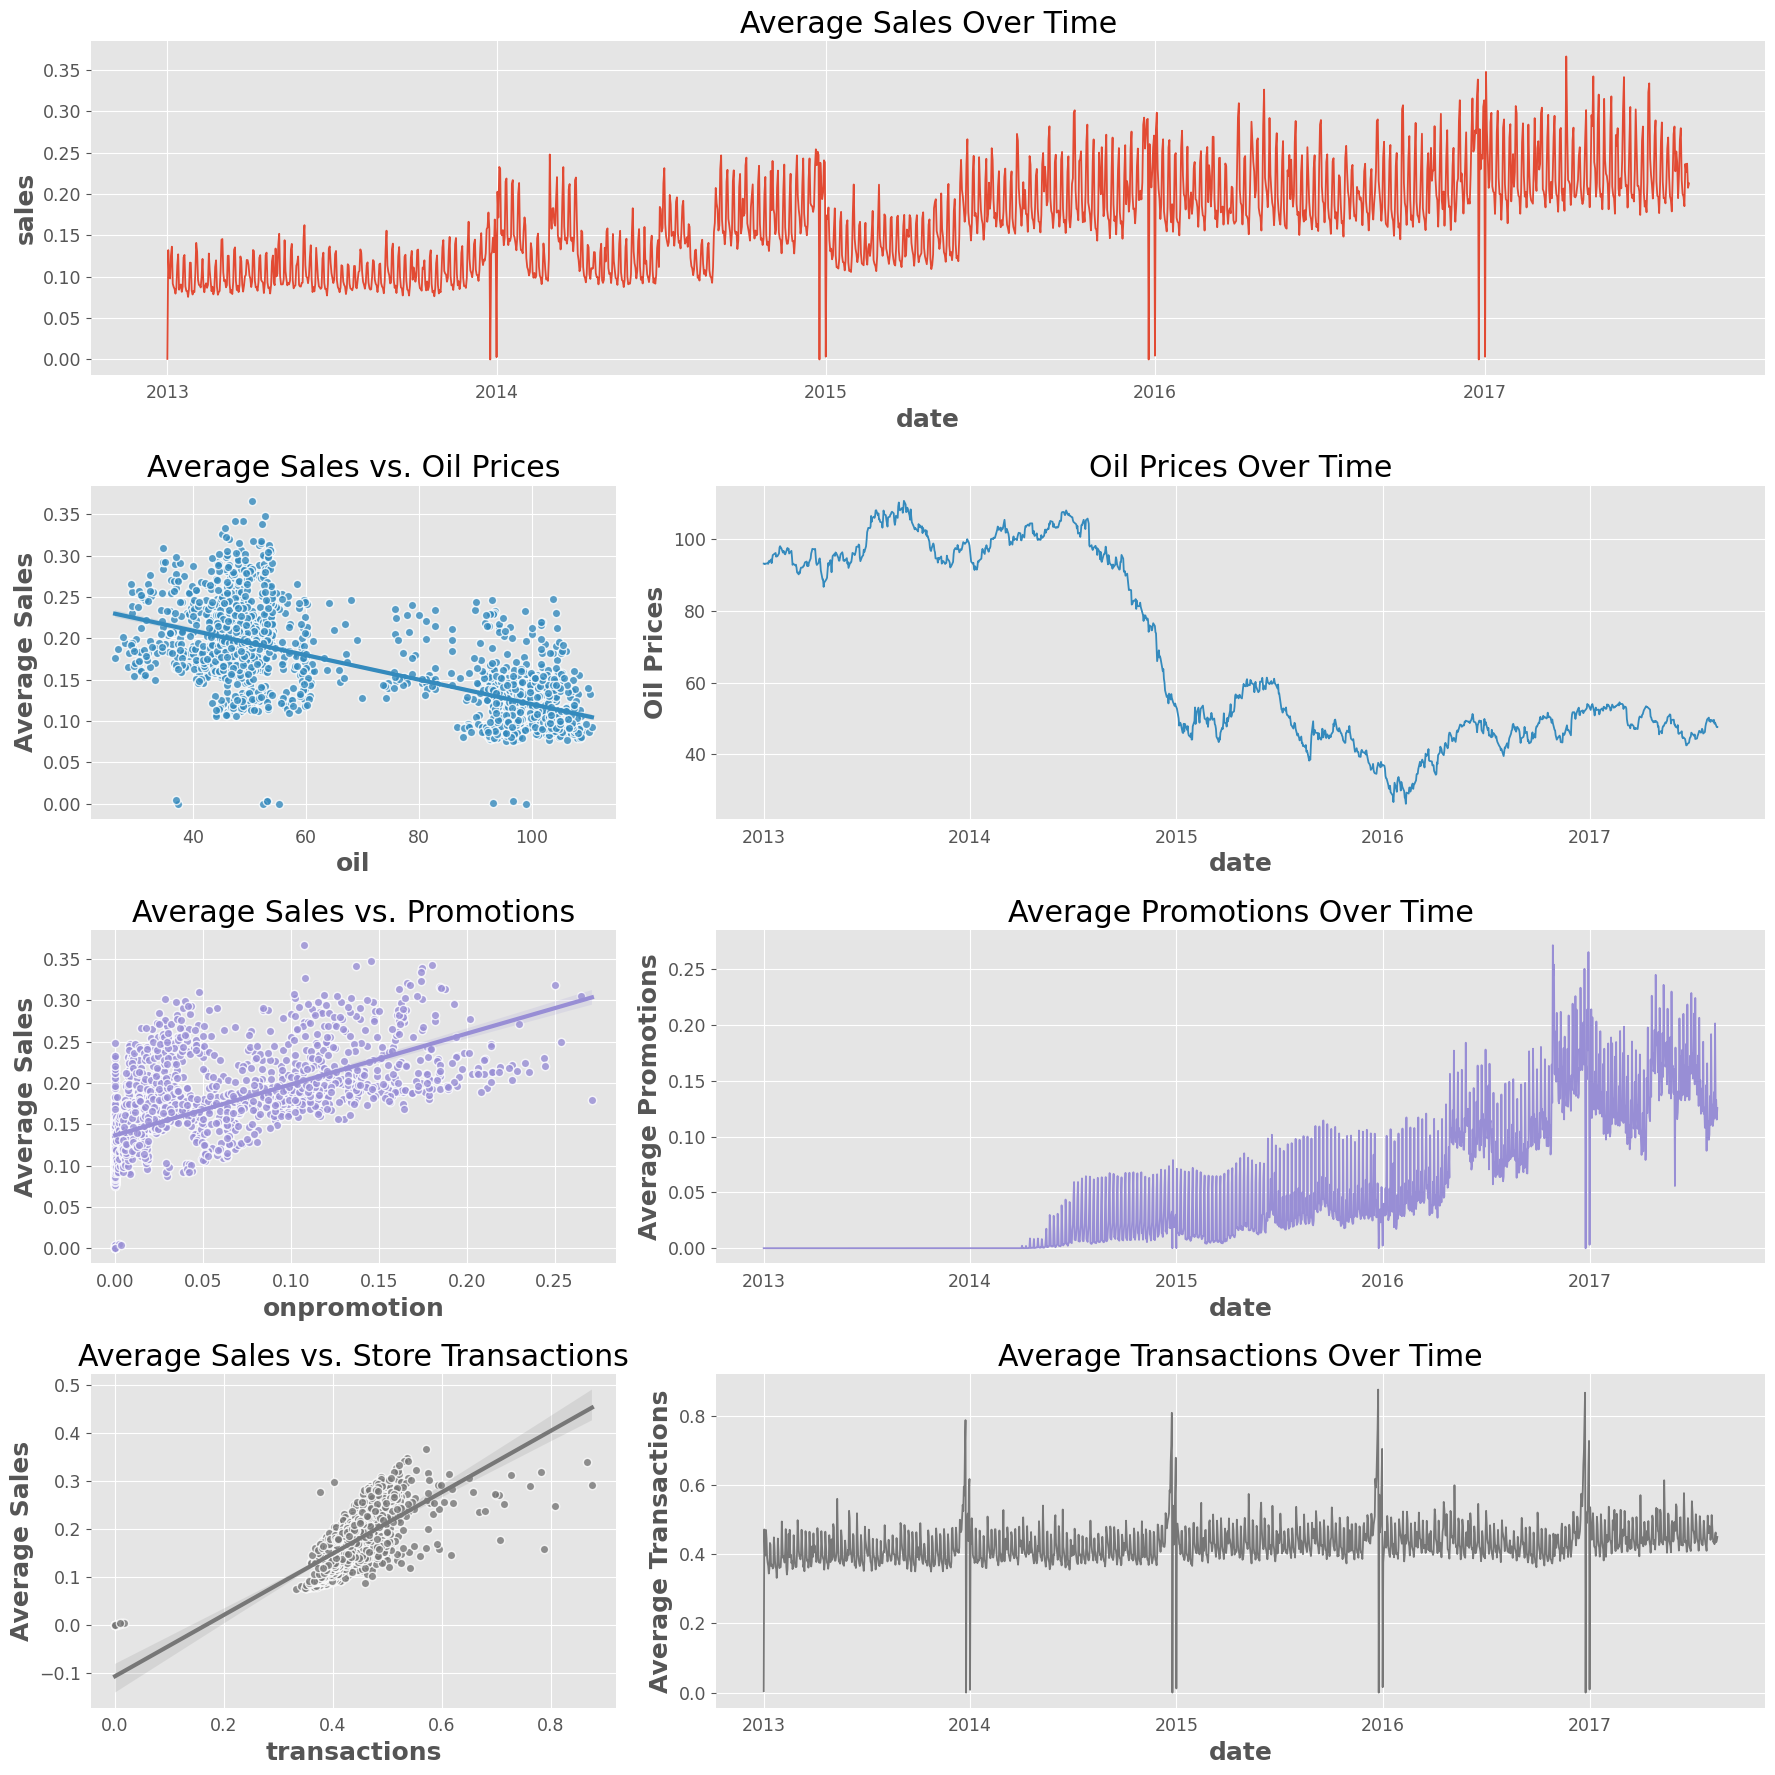

In [21]:
def plot_sales_correlation():   
    tr_ts_scaled = tr_ts.copy()
    tr_ts_scaled[tr_ts_scaled.columns] = scaler.fit_transform(tr_ts_scaled)

    promo_ts_scaled = promo_ts.copy()
    promo_ts_scaled[promo_ts_scaled.columns] = scaler.fit_transform(promo_ts_scaled)
    
    mean_sales_ts_scaled = sales_ts_scaled.mean(axis=1).to_frame("sales").reset_index()
    mean_promo_ts_scaled = promo_ts_scaled.mean(axis=1).to_frame("onpromotion").reset_index()
    mean_tr_ts_scaled = tr_ts_scaled.mean(axis=1).to_frame("transactions").reset_index()
    
    print( 
        "Covariates: oil, onpromotion, transactions",
        "Past covariates  : transactions",
        "Future covariates: oil, onpromotion",
    )

    plot_kwargs = {
        "scatter_kws": {"edgecolor": "white"},
        "line_kws": {"lw": 3},
    }
    
    fig = plt.figure(figsize=(18, 18))
    gs = fig.add_gridspec(4, 2, width_ratios=(1, 2))
    
    sns.lineplot(
        data=mean_sales_ts_scaled,
        x="date",
        y="sales",
        ax=fig.add_subplot(gs[0, :]),
    )
    plt.title("Average Sales Over Time")
    
    sns.regplot(
        x=df_oil.oil.iloc[:train_len], y=mean_sales_ts_scaled.sales,
        ax=fig.add_subplot(gs[1, 0]),
        color=COLORS[1],
        **plot_kwargs,
    )
    plt.ylabel("Average Sales")
    plt.title("Average Sales vs. Oil Prices")
    
    sns.lineplot(
        data=df_oil.iloc[:train_len, :], x="date", y="oil",
        ax=fig.add_subplot(gs[1, 1]),
        color=COLORS[1],
    )
    plt.ylabel("Oil Prices")
    plt.title("Oil Prices Over Time")

    sns.regplot(
        x=mean_promo_ts_scaled.onpromotion, y=mean_sales_ts_scaled.sales,
        ax=fig.add_subplot(gs[2, 0]),
        color=COLORS[2],
        **plot_kwargs,
    )
    plt.xlabel("onpromotion")
    plt.ylabel("Average Sales")
    plt.title("Average Sales vs. Promotions")

    sns.lineplot(
        data=mean_promo_ts_scaled, x="date", y="onpromotion",
        ax=fig.add_subplot(gs[2, 1]),
        color=COLORS[2],
    )
    plt.ylabel("Average Promotions")
    plt.title("Average Promotions Over Time")
    
    sns.regplot(
        x=mean_tr_ts_scaled.transactions, y=mean_sales_ts_scaled.sales,
        ax=fig.add_subplot(gs[3, 0]),
        color=COLORS[3],
        **plot_kwargs,
    )
    plt.xlabel("transactions")
    plt.ylabel("Average Sales")
    plt.title("Average Sales vs. Store Transactions")
    
    sns.lineplot(
        data=mean_tr_ts_scaled, x="date", y="transactions",
        ax=fig.add_subplot(gs[3, 1]),
        color=COLORS[3],
    )
    plt.ylabel("Average Transactions")
    plt.title("Average Transactions Over Time")

    plt.tight_layout()
    plt.show()
    
plot_sales_correlation()

##### Static Covariates: City, State
* Besides past and future covariates, we also have static covariates which are constant over time. The city and state columns from the store data are considered static covariates because they represent unique characteristics of the store and do not change over time. Other examples are store_nbr and family, which we have looked at earlier.

* The stacked bar chart below denotes the number of stores within each state, and the units are labeled by the corresponding store numbers. They are color-coded by each unique city within the state. Using Manabi as an example, store number 54 belongs to one city while store numbers 52, 53 belong to another city.

* We can see that most states only have one color, meaning that there are stores in only one city within each state. Some states like Guayas and Pichincha have stores in multiple cities, but the stores are dominated by one city. In other words, there may not be a noticeable difference between the city-level and state-level impacts on store sales, but this requires some experimentation later.

Static covariates: city, state Number of unique cities                      : 22 Number of unique states                      : 16 Number of states with stores in only one city: 12


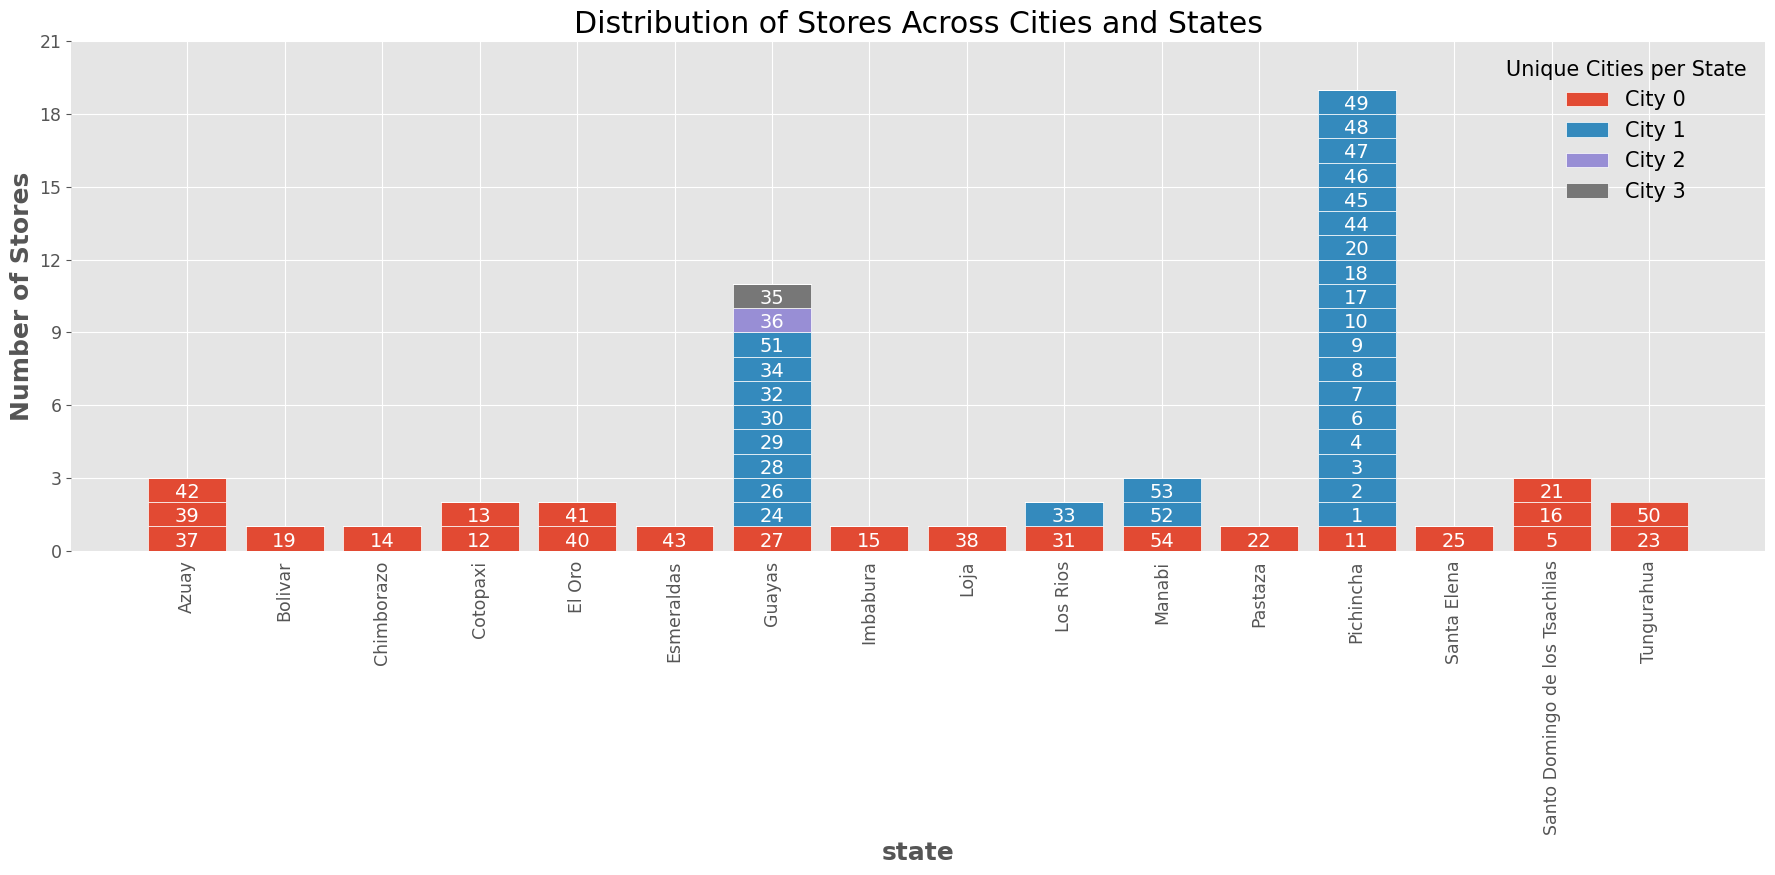

In [22]:
def plot_city_state_distribution(store):
    print(
        "Static covariates: city, state",
        f"Number of unique cities                      : {store.city.nunique()}",
        f"Number of unique states                      : {store.state.nunique()}",
        f"Number of states with stores in only one city: {(store.groupby('state').city.nunique().eq(1)).sum()}",
    )
    
    store = store.copy().sort_values(["state", "city", "store_nbr"])
    state_list = store.state.unique()
    bar_bottom = np.zeros(len(state_list))
    counter = {}

    fig = plt.figure(figsize=(18, 9))
    
    for num in store.store_nbr.unique():
        curr_state, curr_city = store.loc[store.store_nbr.eq(num), ["state", "city"]].values[0]
        if curr_state not in counter:
            counter[curr_state] = []
        if curr_city not in counter[curr_state]:
            counter[curr_state].append(curr_city)
        state_ind = (state_list==curr_state).astype(int)
        plt.bar(
            x=state_list, height=state_ind,
            bottom=bar_bottom,
            color=COLORS[len(counter[curr_state])-1],
            edgecolor="white",
            label=f"City {len(counter[curr_state])-1}",
        )
        bar_bottom += state_ind
        running_total = bar_bottom[np.argmax(state_ind)]
        plt.text(
            x=curr_state, y=running_total-0.6,
            s=num,
            size=14,
            color="white",
            va="center",
            ha="center",
        )
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = sorted(list(set(labels)))
    unique_handles = [handles[labels.index(label)] for label in unique_labels]
    plt.legend(unique_handles, unique_labels, title="Unique Cities per State")
    plt.xticks(rotation=90)
    plt.yticks(list(range(0, 22, 3)))
    plt.xlabel("state")
    plt.ylabel("Number of Stores")
    plt.title("Distribution of Stores Across Cities and States")
    
    plt.tight_layout()
    plt.show()

plot_city_state_distribution(df_stores)

Finding: Most states only have stores in one city. For states with stores in multiple cities, the number of stores is generally dominated by one city. Regional Holidays in these states, cities will affect sales more than states with lower number of stores and cities.

##### Static Covariates: Type, Cluster
* The store data also has other static covariates represented by the type and cluster columns. We have another stacked bar chart which denotes the number of stores within each cluster, and the units are labeled by the corresponding store numbers. In this case, the units are color-coded by the store type that they belong to. For example, stores within clusters 1, 2, 4, 8, 9, 13 are all of the same type.

* Because most clusters only have one color, each of them are dominated by one store type. On the other hand, most store types exist in multiple clusters. This raises the possibility of cluster-level and type-level effects.

Static covariates: cluster, type Number of unique store cluster: 17 Number of unique store type   : 5


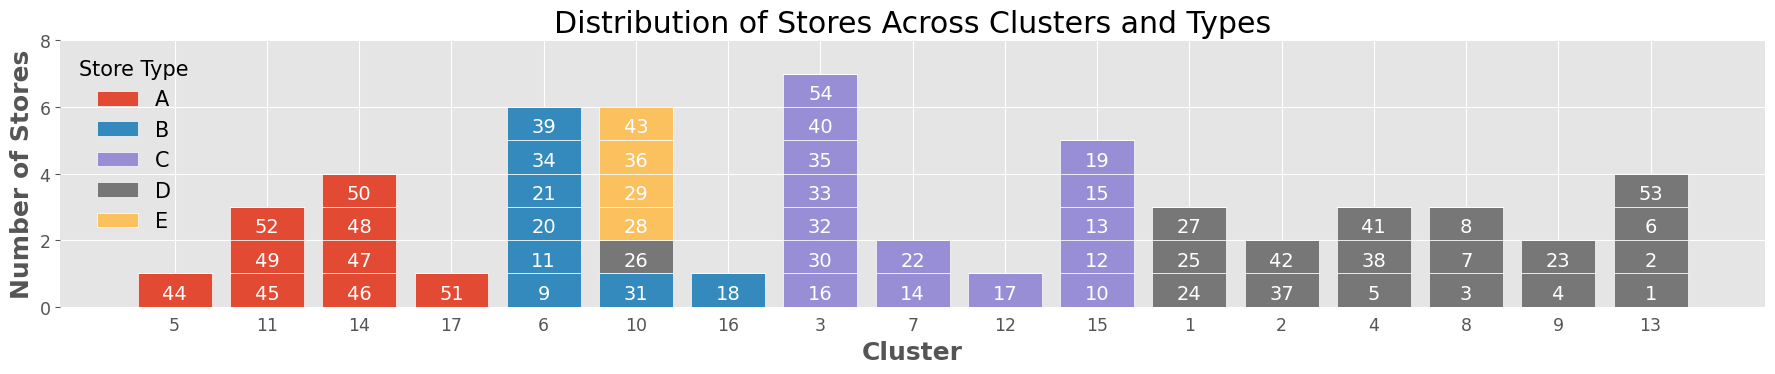

In [23]:
def plot_cluster_type_distribution(store):    
    print(
        "Static covariates: cluster, type",
        f"Number of unique store cluster: {store.cluster.nunique()}",
        f"Number of unique store type   : {store.type.nunique()}",
    )
    store = store.copy().sort_values(["type", "cluster"])
    cluster_list = store.cluster.unique().astype(str)
    type_list = store.type.sort_values().unique()
    bar_bottom = np.zeros(len(cluster_list))
    color_map = {s_type: c for s_type, c in zip(type_list, COLORS)}

    fig = plt.figure(figsize=(18, 4))
    
    for num in store.store_nbr.unique():
        curr_cluster, curr_type = store.loc[store.store_nbr.eq(num), ["cluster", "type"]].astype(str).values[0]
        cluster_ind = (cluster_list==curr_cluster).astype(int)
        plt.bar(
            x=cluster_list, height=cluster_ind,
            bottom=bar_bottom,
            zorder=2,
            color=color_map[curr_type],
            label=curr_type,
            edgecolor="white",
        )
        bar_bottom += cluster_ind
        running_total = bar_bottom[np.argmax(cluster_ind)]
        plt.text(
            x=curr_cluster, y=running_total-0.6,
            s=num,
            size=14,
            color="white",
            va="center",
            ha="center",
        )
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = sorted(list(set(labels)))
    unique_handles = [handles[labels.index(label)] for label in unique_labels]
    plt.legend(unique_handles, unique_labels, title="Store Type")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Stores")
    plt.yticks(list(range(0, 9, 2)))
    plt.title("Distribution of Stores Across Clusters and Types")
    
    plt.tight_layout()
    plt.show()
    
plot_cluster_type_distribution(df_stores)

Finding: Each cluster is dominated by one store type, and most store types have multiple clusters.

#### Sales Trends according to Date
* Date-related features like the month and year of each data point are considered future covariates because they are fixed and thus known in advance. To prevent the influence of holiday effects, we make sure to filter the data to only include non-holiday periods. We attempt to look at the distribution of sales for each covariate using boxplots. Some covariates like the days of the year have really large numbers of categories (365-366 days in a year), so inspecting that many boxplots may not be plausible. For such cases, we just compute the average sales (across all the target series) for each time period. The following date-related features are created:

    1. *Day*. With paydays being on the 15th and the last day of the month, we see that the sales tend to vary more around the same periods. In particular, this is more noticeable at the end/start of the month.
    2. *Month*. While most of the boxplots look the same, the sales tend to vary greatly in December. This could be a seasonal pattern in which people prepare early for Christmas or New Year's Day.
    3. *Year*. It is clear from the boxplots that the sales have a general upward trend across the year.
    4. *Day_of_week* Sales tend to be greater on weekends, which are non-working days for most people. It is reasonable to say that they have more time to visit the grocery stores, which translates to greater sales.
    5. *Day_of_year* / *Week_of_year*. The days of the year and weeks of the year give similar information to the months, but at different levels of granularity. To illustrate, while sales in the first week tend to be large, sales for the first day of the year is very small.
    6. *Date_index* The date index (index of the target series) gives similar information to the years, but at a higher level of granularity. There are some greater fluctuations in the first half of the time period.

Future covariates: day, month, year, day_of_week, day_of_year, week_of_year, date_index day                     : paydays on the 15th and last day of the month month                   : monthly seasonal patterns year                    : general trends day_of_week             : weekdays vs. weekends day_of_year/week_of_year: different levels of granularity from month date_index              : higher level of granularity than year


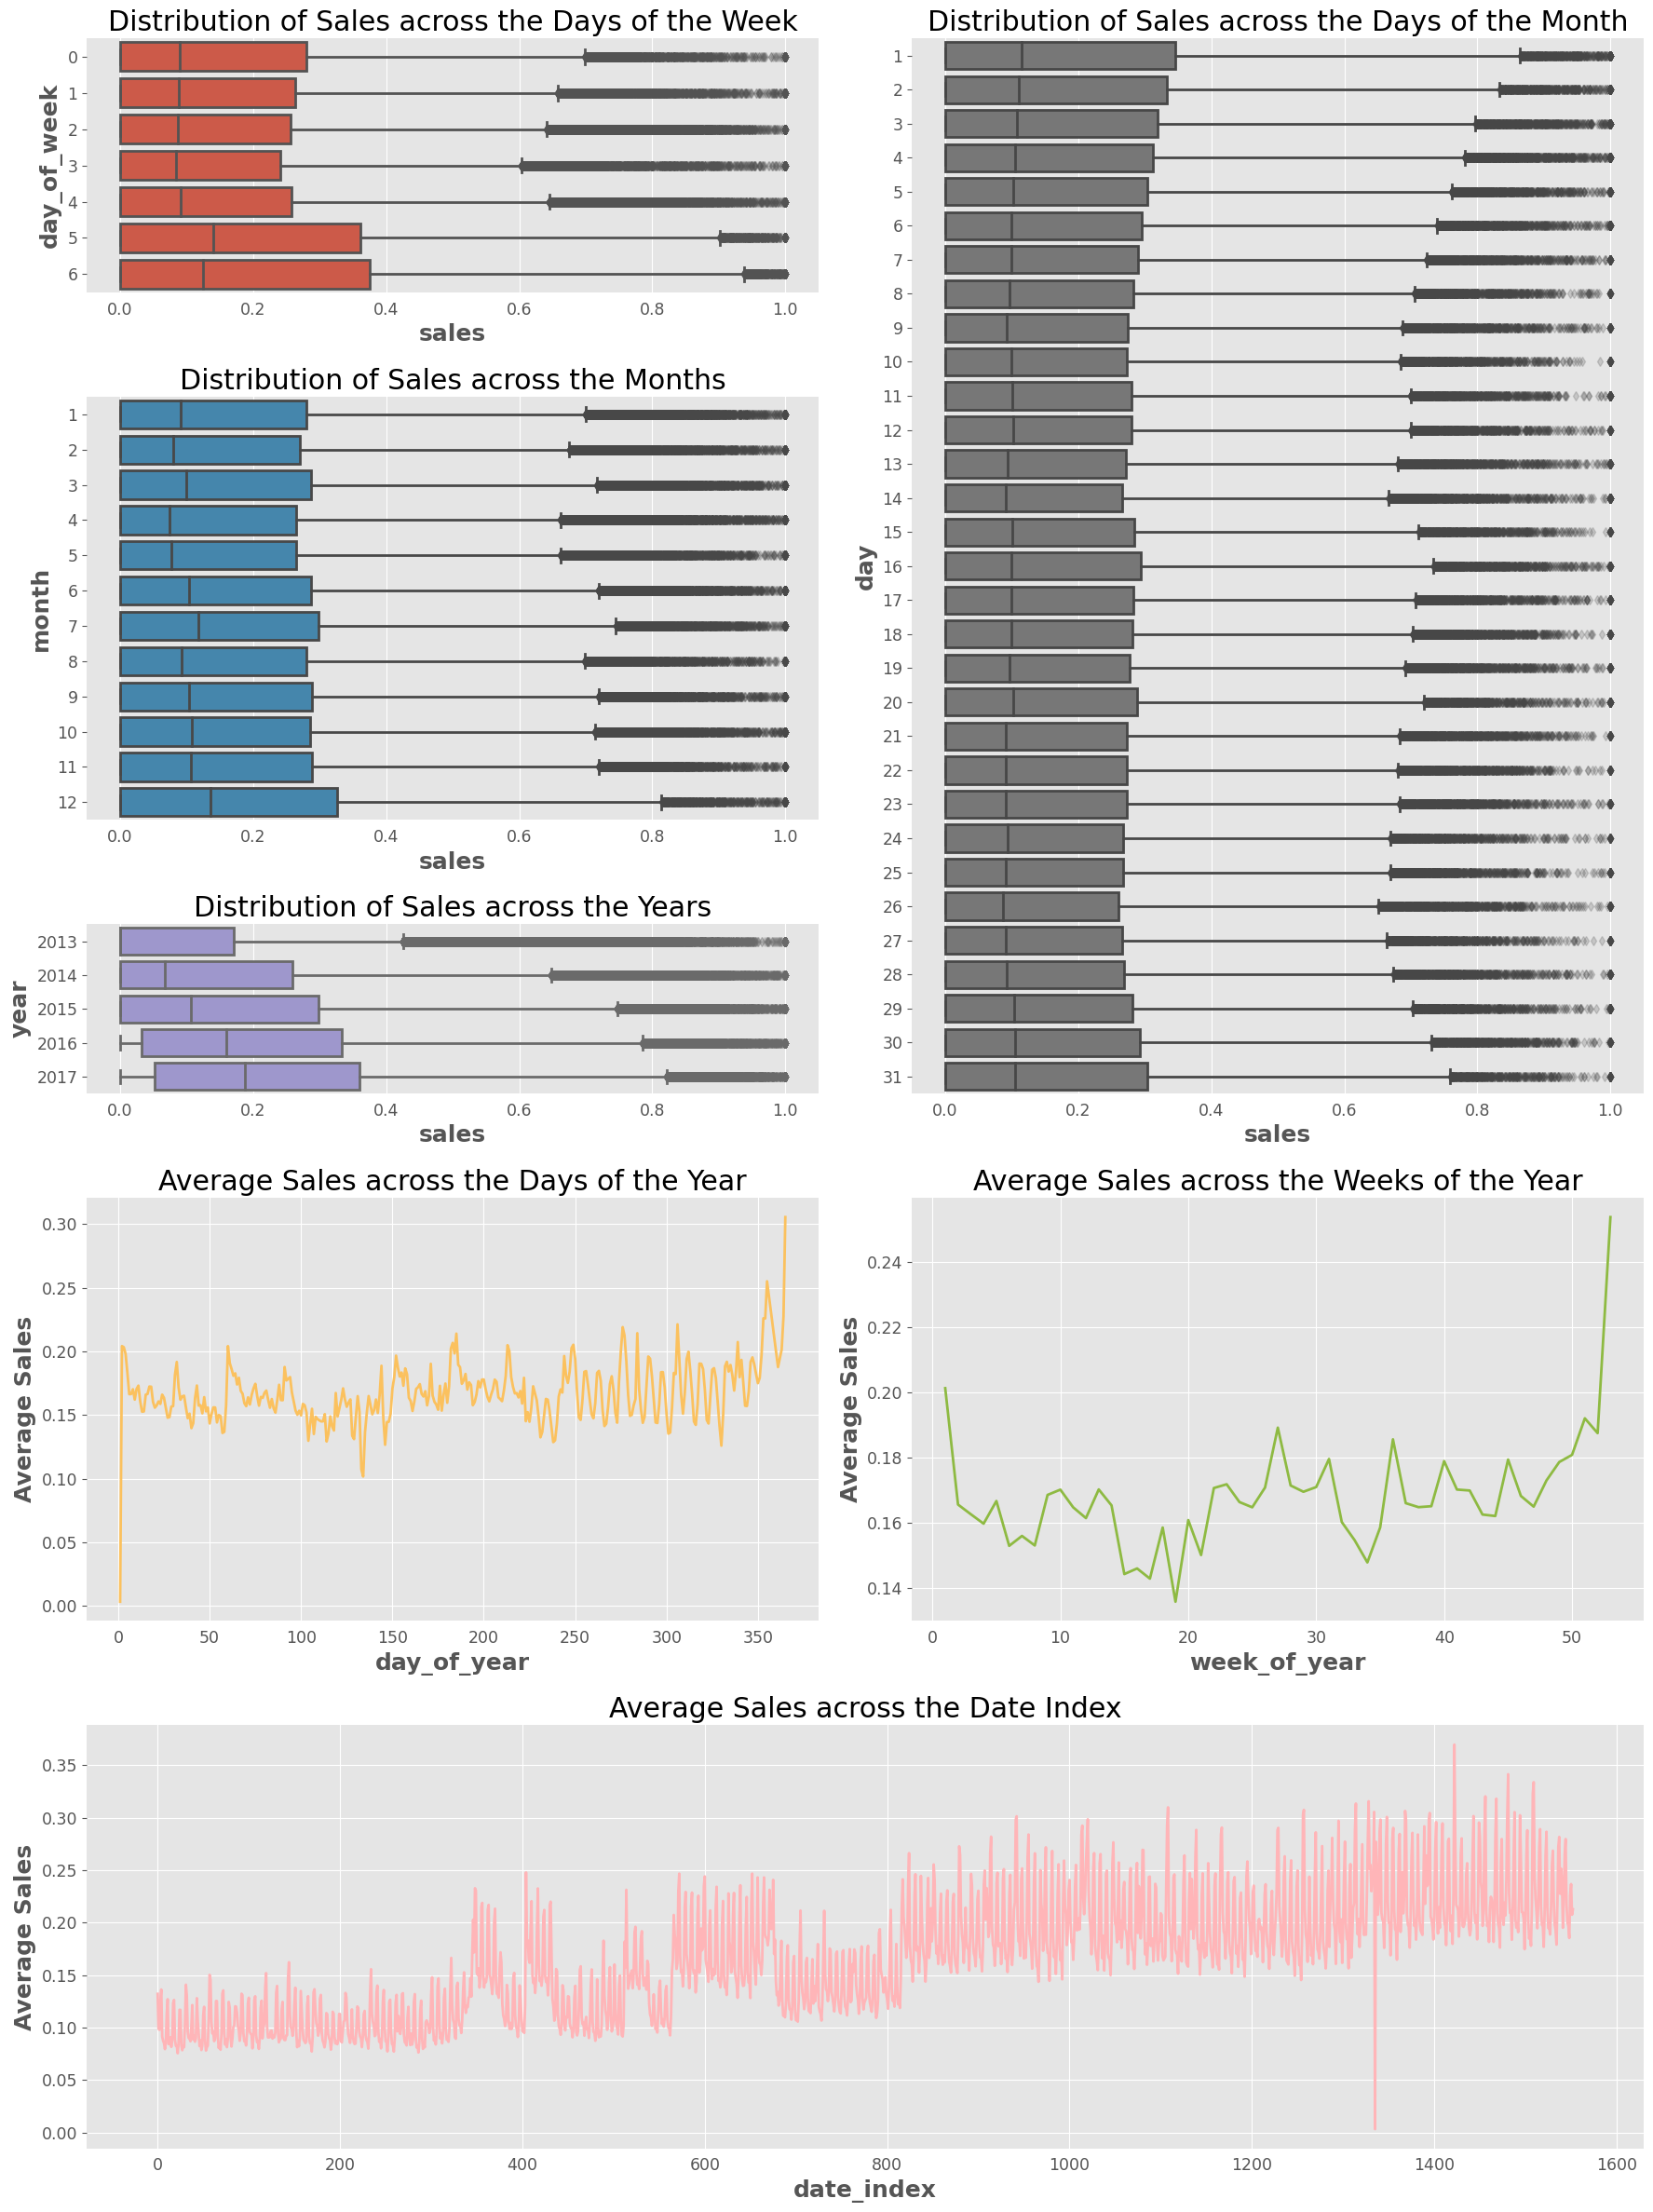

In [24]:
def plot_date_distribution():   
    df = holiday_sales_merged.copy().sort_values(["date", "store_nbr", "family"], ignore_index=True)
    df = df[df.no_holiday.eq(1)].reset_index(drop=True)
    df["day"] = df.date.dt.day
    df["month"] = df.date.dt.month
    df["year"] = df.date.dt.year
    df["day_of_week"] = df.date.dt.dayofweek
    df["day_of_year"] = df.date.dt.dayofyear
    df["week_of_year"] = df.date.dt.isocalendar().week.astype(int)
    df["date_index"] = df.date.factorize()[0]
    
    print(
        "Future covariates: day, month, year, day_of_week, day_of_year, week_of_year, date_index",
        "day                     : paydays on the 15th and last day of the month",
        "month                   : monthly seasonal patterns",
        "year                    : general trends",
        "day_of_week             : weekdays vs. weekends",
        "day_of_year/week_of_year: different levels of granularity from month",
        "date_index              : higher level of granularity than year",
    )
    
    plot_kwargs = {
        "linewidth": 2,
        "flierprops": {"alpha": 0.2},
        "orient": "h",
    }
    
    fig = plt.figure(figsize=(18, 24))
    gs = fig.add_gridspec(5, 2, height_ratios=(3, 5, 2, 5, 5))
    
    sns.boxplot(
        data=df,
        y="day_of_week",
        x="sales",
        color=COLORS[0],
        ax=fig.add_subplot(gs[0, 0]),
        **plot_kwargs,
    )
    plt.title("Distribution of Sales across the Days of the Week")
    
    sns.boxplot(
        data=df,
        y="month",
        x="sales",
        color=COLORS[1],
        ax=fig.add_subplot(gs[1, 0]),
        **plot_kwargs,
    )
    plt.title("Distribution of Sales across the Months")
    
    sns.boxplot(
        data=df,
        y="year",
        x="sales",
        color=COLORS[2],
        ax=fig.add_subplot(gs[2, 0]),
        **plot_kwargs,
    )
    plt.title("Distribution of Sales across the Years")
    
    sns.boxplot(
        data=df,
        y="day",
        x="sales",
        color=COLORS[3],
        ax=fig.add_subplot(gs[:3, 1]),
        **plot_kwargs,
    )
    plt.title("Distribution of Sales across the Days of the Month")
    
    sns.lineplot(
        data=df.groupby("day_of_year").sales.mean().reset_index(),
        x="day_of_year",
        y="sales",
        color=COLORS[4],
        ax=fig.add_subplot(gs[3, 0]),
        linewidth=2,
    )
    plt.ylabel("Average Sales")
    plt.title("Average Sales across the Days of the Year")
    
    sns.lineplot(
        data=df.groupby("week_of_year").sales.mean().reset_index(),
        x="week_of_year",
        y="sales",
        color=COLORS[5],
        ax=fig.add_subplot(gs[3, 1]),
        linewidth=2,
    )
    plt.ylabel("Average Sales")
    plt.title("Average Sales across the Weeks of the Year")
    
    sns.lineplot(
        data=df.groupby("date_index").sales.mean().reset_index(),
        x="date_index",
        y="sales",
        color=COLORS[6],
        ax=fig.add_subplot(gs[4, :]),
        linewidth=2,
    )
    plt.ylabel("Average Sales")
    plt.title("Average Sales across the Date Index")
    
    plt.tight_layout()
    plt.show()
    
plot_date_distribution()

### Holidays
Holidays/events are future covariates because the dates are usually known in advance. For simplicity, we will just use the term 'holiday' to denote both holidays and events throughout this notebook. As mentioned earlier, we need to compare sales between holiday and non-holiday periods. Looking at the boxplots below for each holiday, we note that some have larger impacts on sales. Examples are Labor Day (dia trabago), Christmas (navidad), and the 2016 earthquake (terremoto). We need to select the more useful ones to include in our models later.

Future covariate: national holidays
 Number of unique national holidays: 15


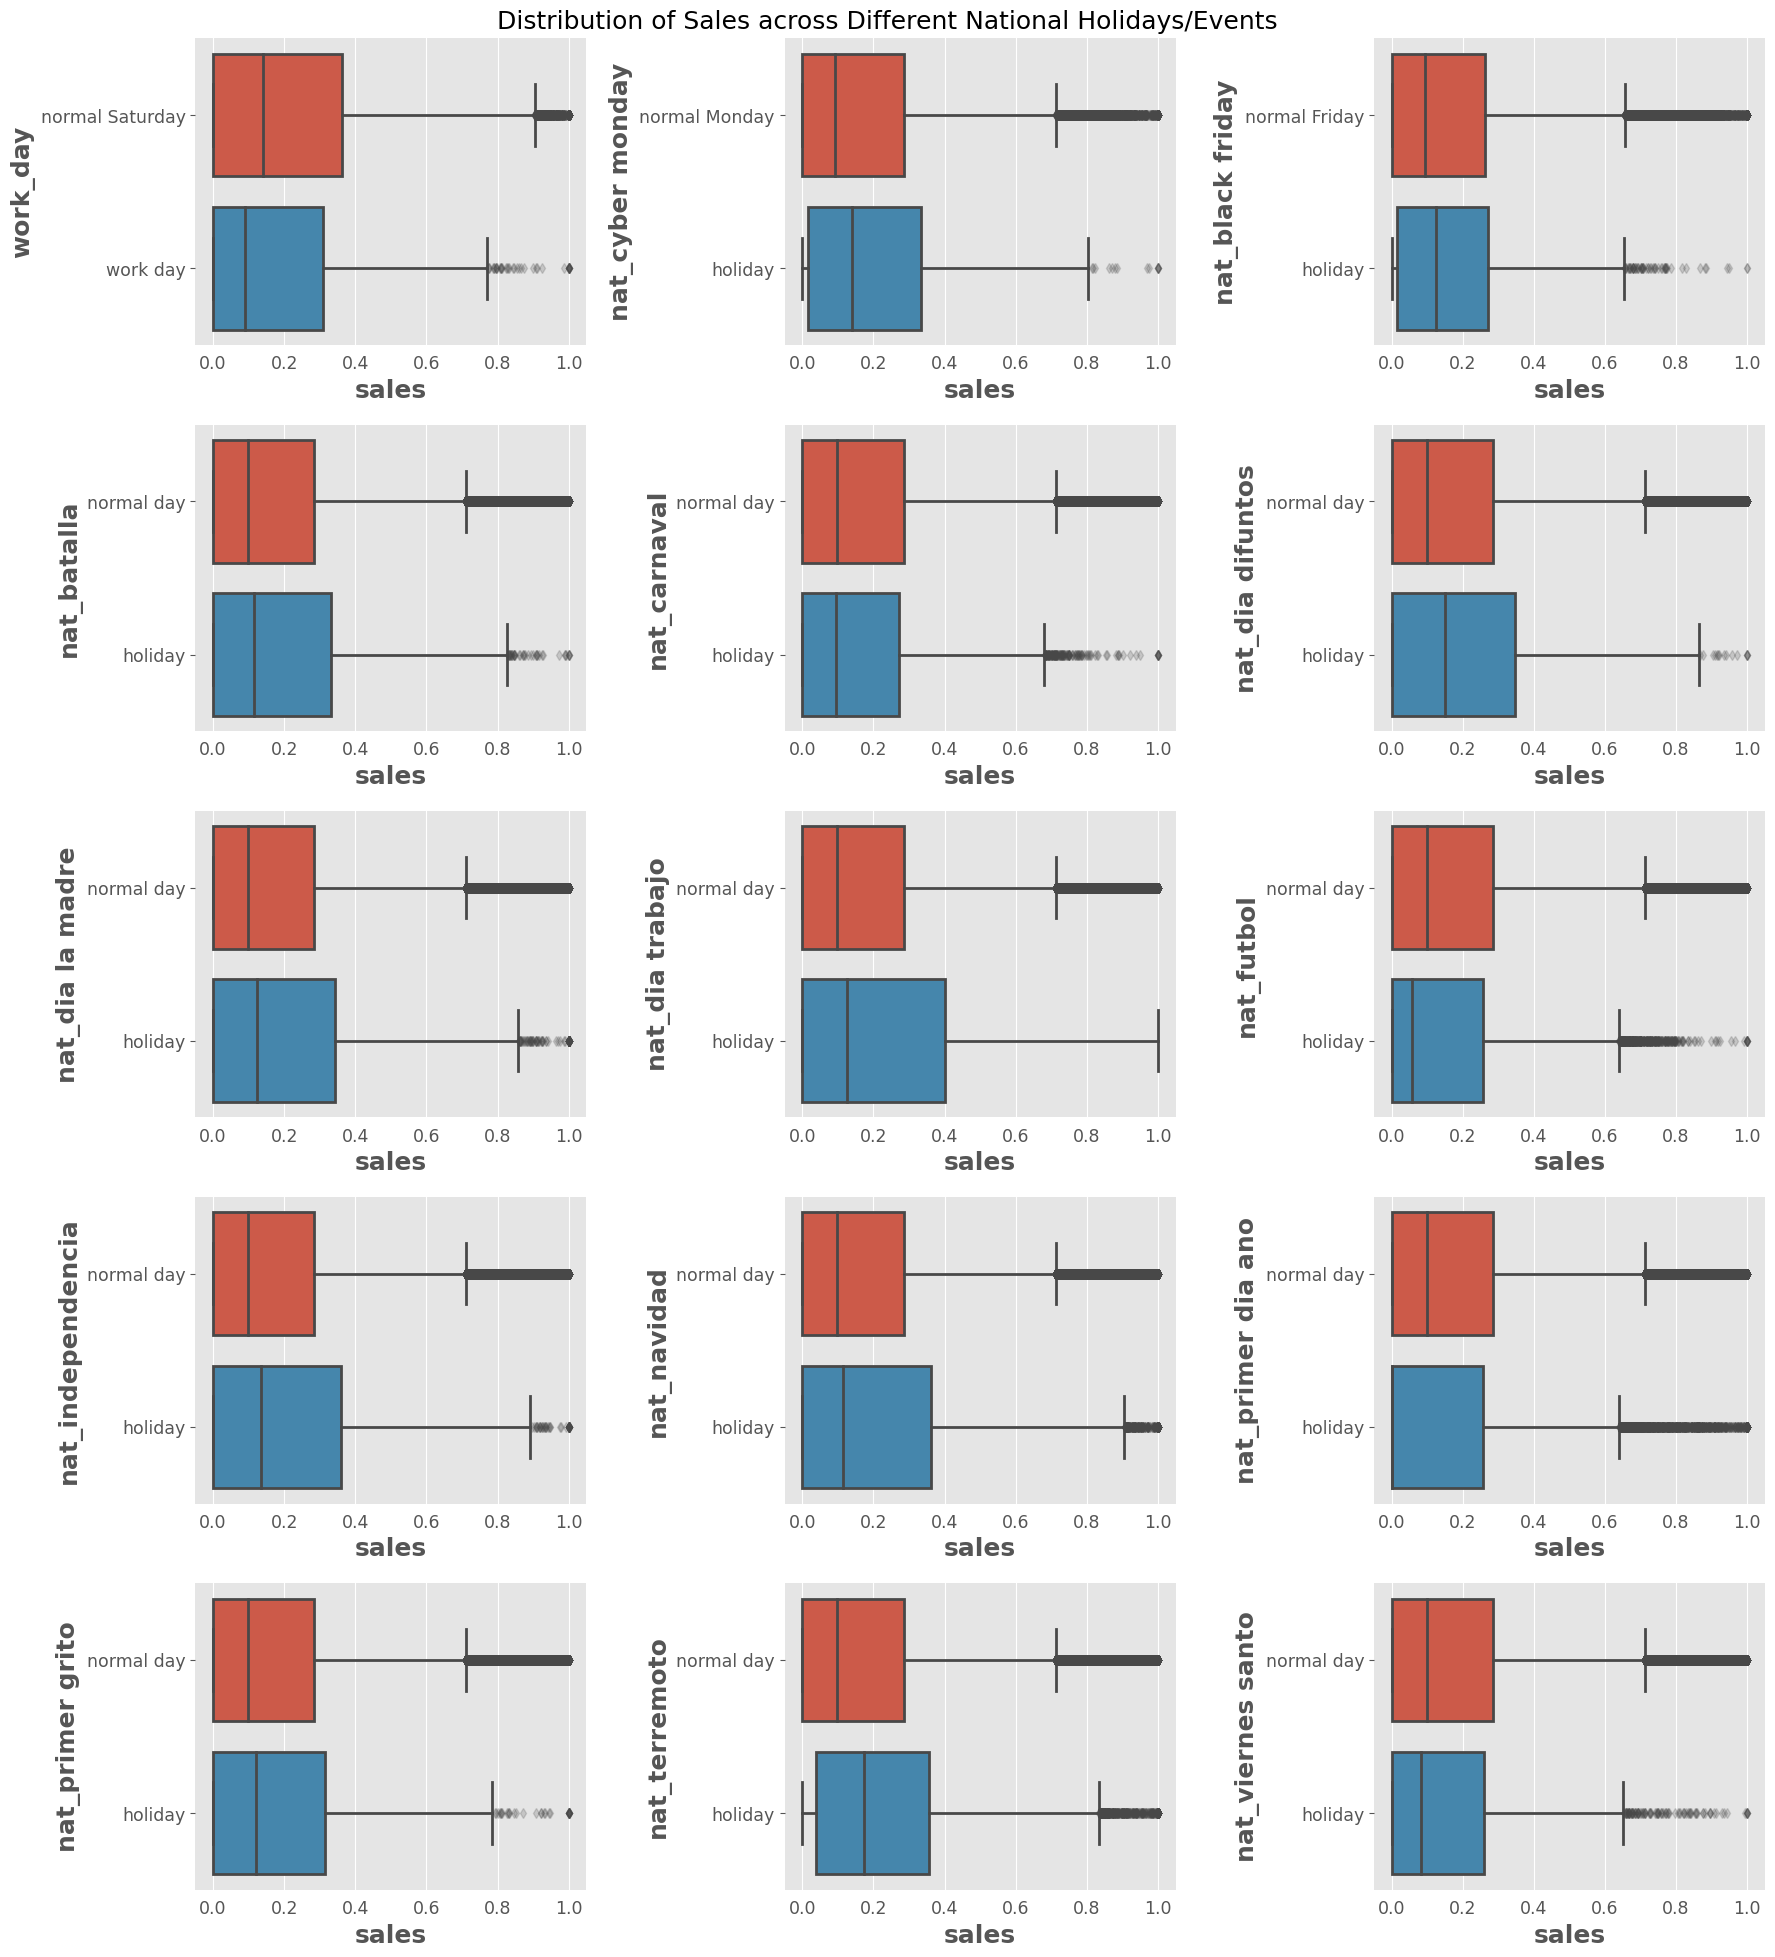

In [25]:
def plot_national_holiday_distribution():
    df = holiday_sales_merged.copy()    
    holiday_list = national_holidays.columns[1:]
    
    print(
        "Future covariate: national holidays\n",
        f"Number of unique national holidays: {len(holiday_list)+1}"
    )
    
    plot_kwargs = {
        "palette": COLORS[:2],
        "linewidth": 2,
        "flierprops": {"alpha": 0.2},
        "orient": "h",
    }
    
    fig = plt.figure(figsize=(18, 20))

    sns.boxplot(
        data=df[(df.date.dt.weekday.eq(5)) & (df.no_holiday.eq(1))],
        y="work_day",
        x="sales",
        ax=fig.add_subplot(531),
        **plot_kwargs,
    )
    plt.yticks([0, 1], ["normal Saturday", "work day"])

    sns.boxplot(
        data=df[(df.date.dt.weekday.eq(0))],
        y="nat_cyber monday",
        x="sales",
        ax=fig.add_subplot(532),
        **plot_kwargs,
    )
    plt.yticks([0, 1], ["normal Monday", "holiday"])
    
    sns.boxplot(
        data=df[(df.date.dt.weekday.eq(4))],
        y="nat_black friday",
        x="sales",
        ax=fig.add_subplot(533),
        **plot_kwargs,
    )
    plt.yticks([0, 1], ["normal Friday", "holiday"])
    
    for j, hol in enumerate(holiday_list.drop(["nat_cyber monday", "nat_black friday"])):
        sns.boxplot(
            data=df[(df[hol].eq(1)) | (df.no_holiday.eq(1))],
            y=hol,
            x="sales",
            ax=fig.add_subplot(5, 3, j+4),
            **plot_kwargs,
        )
        plt.yticks([0, 1], ["normal day", "holiday"])
        
    plt.suptitle("Distribution of Sales across Different National Holidays/Events")
    plt.tight_layout()
    plt.show()

plot_national_holiday_distribution()

Some national holidays/events like Labor Day, Christmas, and the 2016 earthquake have larger impacts on sales.

### Zero Sales Series
Our training data has 53 target series with all values equal to zero. This could be due to poor sales performance or product unavailability. What is interesting here is that all stores have about 0 to 3 zero constant target series. If we consider this by the product family, books have the most number of zero constant target series. It appears that the problem of zero sales could be due to the type of product being sold.

Constant target series
 Number of constant target series: 53
 List of unique constant values  : [0.0]


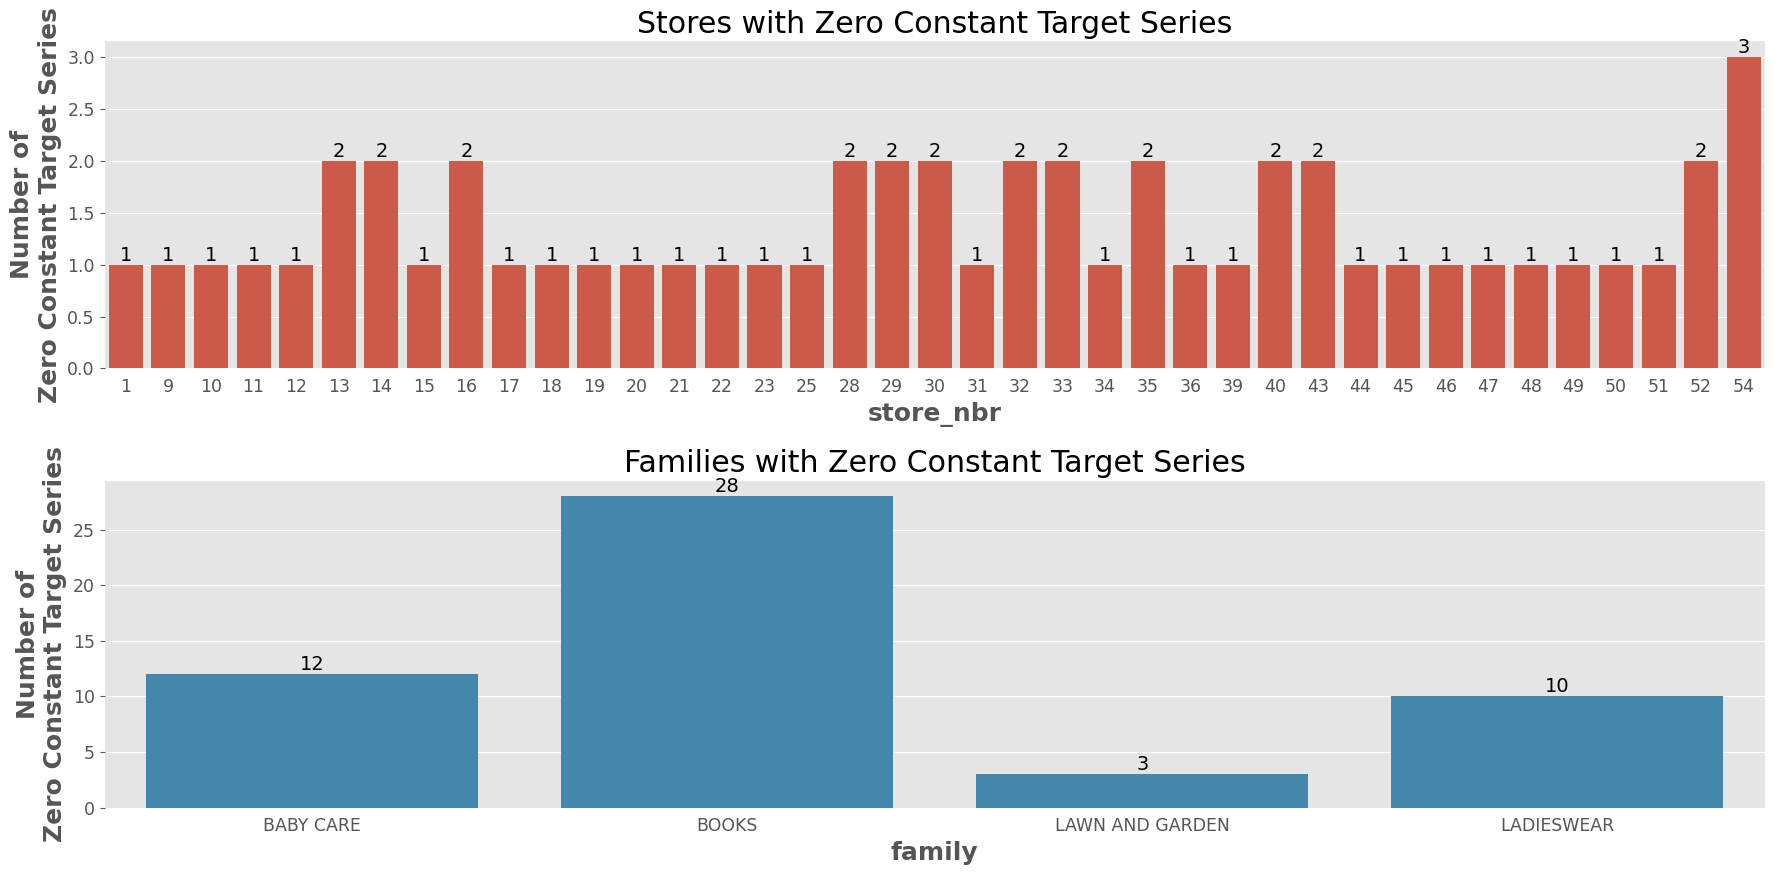

In [58]:
def plot_constant_ts_distribution():
    const_ts = sales_ts.iloc[:, (sales_ts.std()==0).tolist()]
    const_ts_labels = const_ts.columns.to_frame().reset_index(drop=True)
    
    print(
        "Constant target series\n",
        f"Number of constant target series: {len(const_ts.columns)}\n",
        f"List of unique constant values  : {const_ts.iloc[0].unique().tolist()}",
    )
    
    fig = plt.figure(figsize=(18, 9))

    ax0 = sns.countplot(
        data=const_ts_labels, x="store_nbr",
        color=COLORS[0],
        ax=fig.add_subplot(211),
    )
    ax0.bar_label(ax0.containers[0], size=14)
    plt.ylabel("Number of\nZero Constant Target Series")
    plt.title("Stores with Zero Constant Target Series")

    ax1 = sns.countplot(
        data=const_ts_labels, x="family",
        color=COLORS[1],
        ax=fig.add_subplot(212),
    )
    ax1.bar_label(ax1.containers[0], size=14)
    plt.ylabel("Number of\nZero Constant Target Series")
    plt.title("Families with Zero Constant Target Series")

    plt.tight_layout()
    plt.show()
    
plot_constant_ts_distribution()

We look at some possible patterns of zero store sales. The zero constant target series are removed to get a better picture of the remaining target series. It turns out that we have many target series with leading zeros, with some series consisting of thousands of leading zeros. This suggests the possibility of product unavailability, or simply poor sales performance at the start.

We note that the distribution of leading zeros is fairly consistent across the stores, with only a few stores having the boxplots lying above the rest. Examples are store numbers 52, 53. This could mean that some stores are more recently open, so there are no sales at the start of the target series.

On the other hand, the distribution of leading zeros varies across the families of products. This suggests that the problem of leading zeros could be related to the type of products, like the target series for books all having thousands of leading zeros. This supports the previous finding above.

Time series with leading zeros (excluding zero constant target series)
 Total number of time series                : 1729
 Number of time series with >1 leading zeros: 865


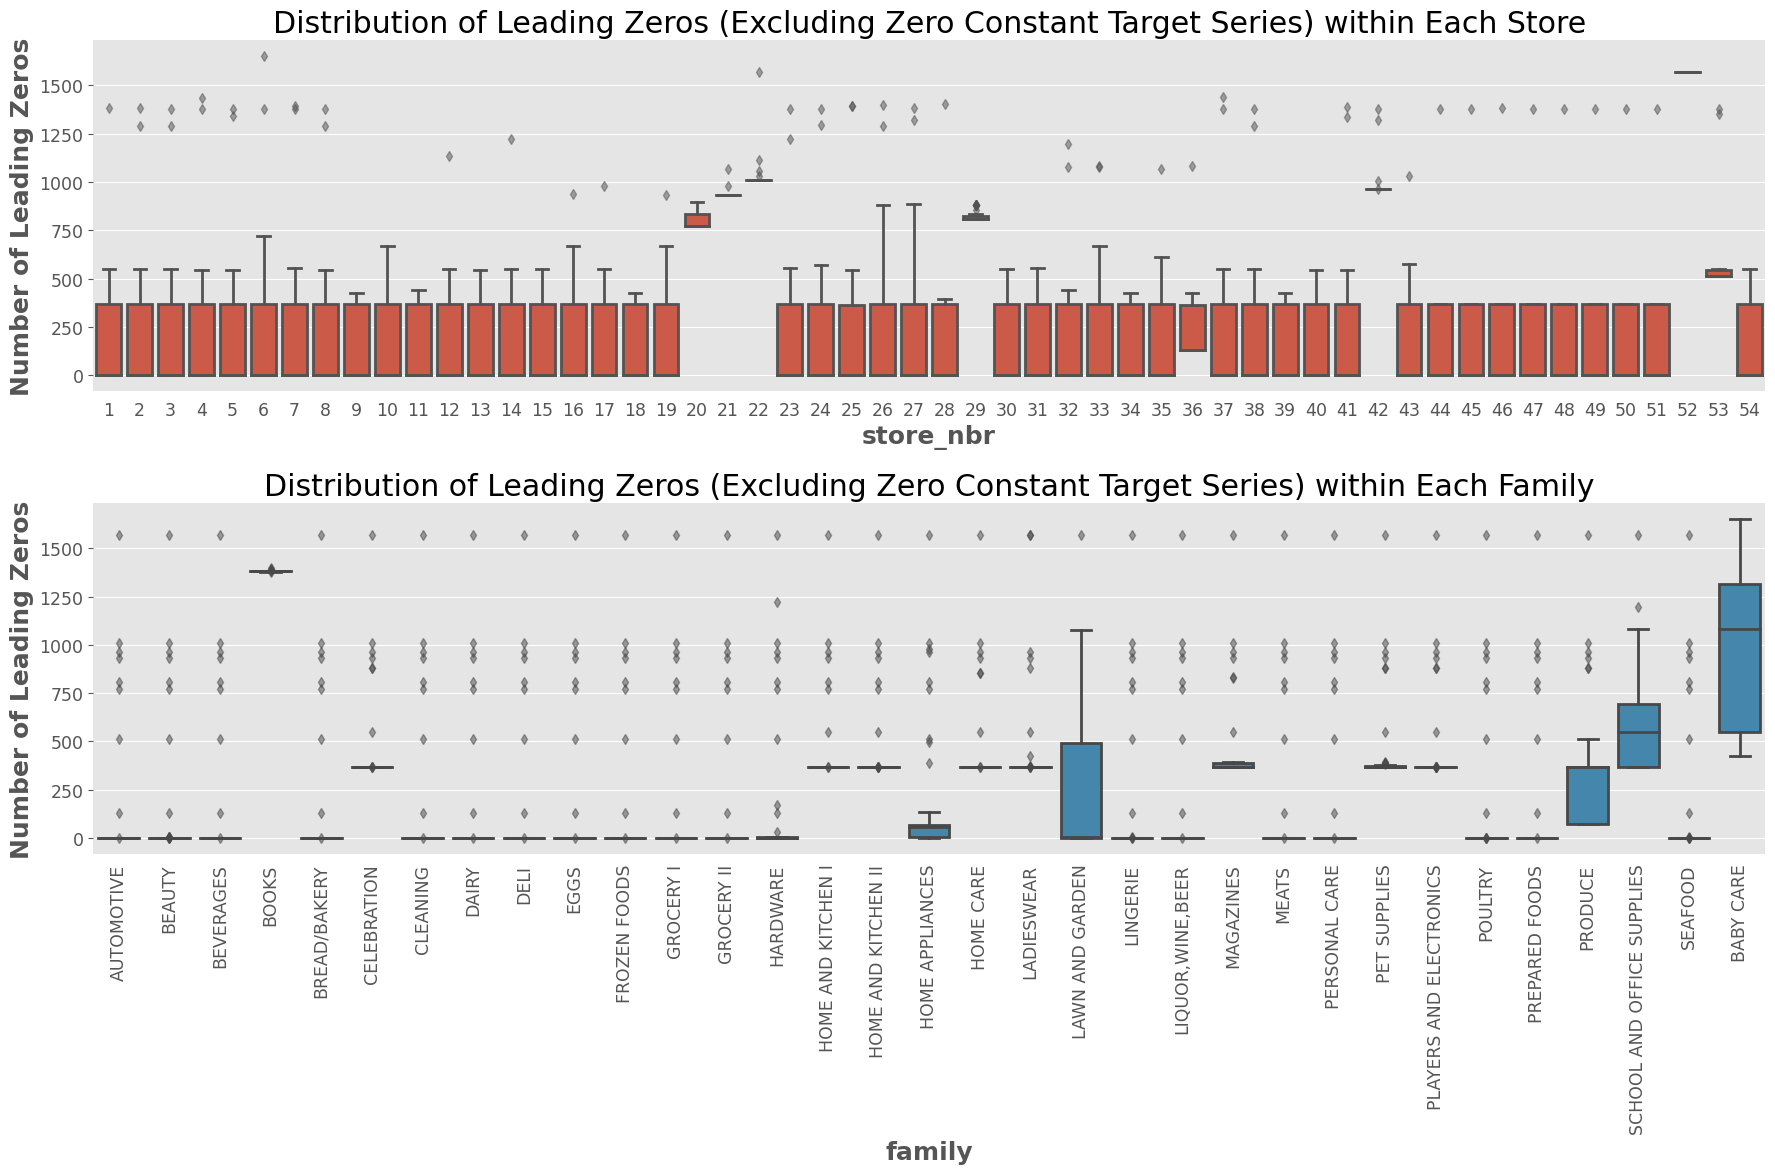

In [59]:
def count_leading_zeros(x):
    nonzero_idx = np.where(x!=0)[0]
    if len(nonzero_idx) > 0:
        return nonzero_idx[0]
    else:
        return len(x)

def plot_leading_zeros_distribution():
    leading_zeros = sales_ts.apply(count_leading_zeros).to_frame("num_leading_zeros").reset_index()
    leading_zeros = leading_zeros[leading_zeros.num_leading_zeros.lt(train_len)]
    
    print(
        "Time series with leading zeros (excluding zero constant target series)\n",
        f"Total number of time series                : {len(leading_zeros.index)}\n",
        f"Number of time series with >1 leading zeros: {leading_zeros.num_leading_zeros.gt(1).sum()}",
    )
    
    plot_kwargs = {
        "linewidth": 2,
        "flierprops": {"alpha": 0.5},
    }
    
    fig = plt.figure(figsize=(18, 12))
    
    ax0 = sns.boxplot(
        data=leading_zeros, x="store_nbr", y="num_leading_zeros",
        color=COLORS[0],
        ax=fig.add_subplot(211),
        **plot_kwargs,
    )
    plt.ylabel("Number of Leading Zeros")
    plt.title("Distribution of Leading Zeros (Excluding Zero Constant Target Series) within Each Store")

    ax1 = sns.boxplot(
        data=leading_zeros, x="family", y="num_leading_zeros",
        color=COLORS[1],
        ax=fig.add_subplot(212),
        **plot_kwargs,
    )
    plt.xticks(rotation=90)
    plt.ylabel("Number of Leading Zeros")
    plt.title("Distribution of Leading Zeros (Excluding Zero Constant Target Series) within Each Family")

    plt.tight_layout()
    plt.show()

plot_leading_zeros_distribution()

We can also examine the number of trailing zeros at the end of the target series. Similarly, we remove the zero constant target series here. There are not as many target series with trailing zeros, suggesting consistent sales across the years.

However, the presence of target series having hundreds of trailing zeros could be due to poor sales performance or that the product is no longer available towards the end. An example would be lawn and garden. In this case, generating zero forecasts for such target series would be a reasonable approach.

Target series with trailing zeros (excluding zero constant target series)
 Total number of time series                : 1729
 Number of target series with trailing zeros: 208


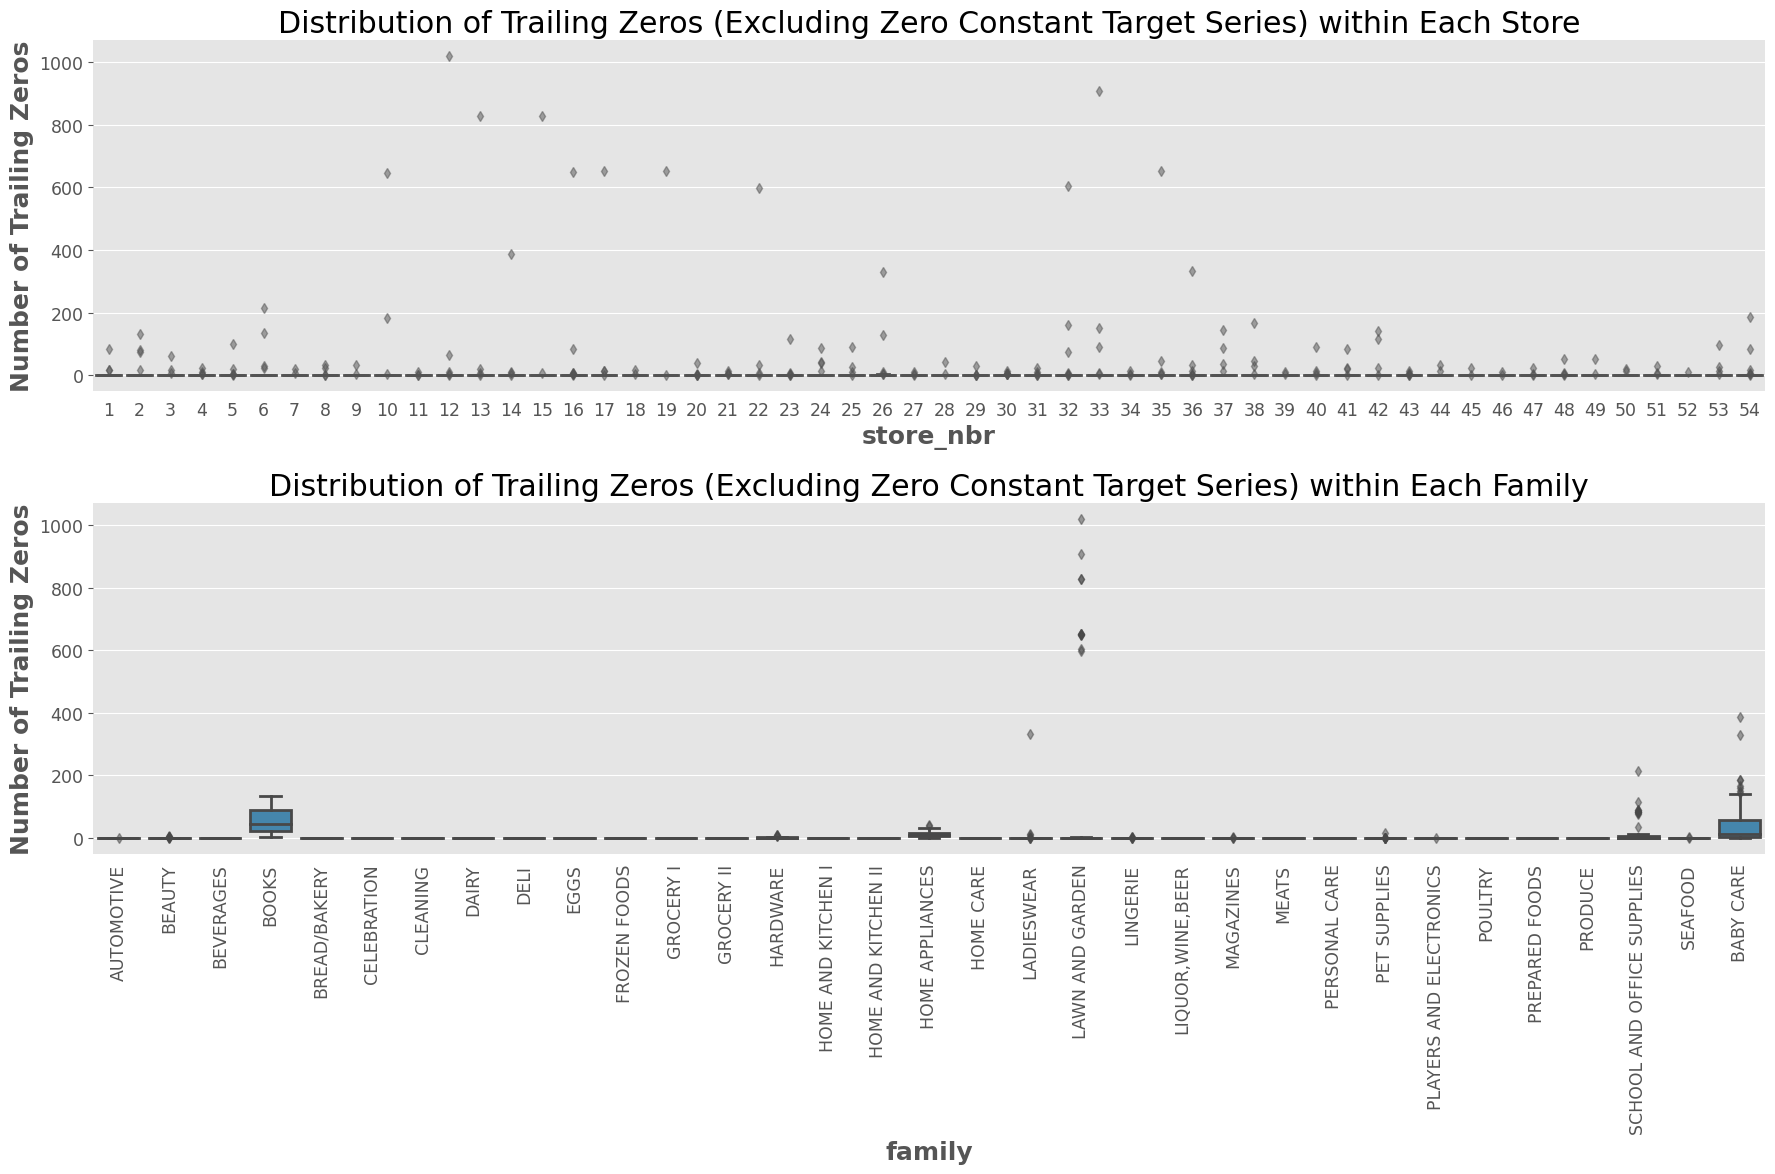

In [61]:
def count_trailing_zeros(x):
    nonzero_idx = np.where(x!=0)[0]
    if len(nonzero_idx) > 0:
        return len(x) - nonzero_idx[-1] - 1
    else:
        return len(x)

def plot_trailing_zeros_distribution():
    trailing_zeros = sales_ts.apply(count_trailing_zeros).to_frame("num_trailing_zeros").reset_index()
    trailing_zeros = trailing_zeros[trailing_zeros.num_trailing_zeros.lt(train_len)]
    
    print(
        "Target series with trailing zeros (excluding zero constant target series)\n",
        f"Total number of time series                : {len(trailing_zeros.index)}\n",
        f"Number of target series with trailing zeros: {trailing_zeros.num_trailing_zeros.gt(0).sum()}",
    )
    
    plot_kwargs = {
        "linewidth": 2,
        "flierprops": {"alpha": 0.5},
    }
    
    fig = plt.figure(figsize=(18, 12))
    
    ax0 = sns.boxplot(
        data=trailing_zeros, x="store_nbr", y="num_trailing_zeros",
        color=COLORS[0],
        ax=fig.add_subplot(211),
        **plot_kwargs,
    )
    plt.ylabel("Number of Trailing Zeros")
    plt.title("Distribution of Trailing Zeros (Excluding Zero Constant Target Series) within Each Store")

    ax1 = sns.boxplot(
        data=trailing_zeros, x="family", y="num_trailing_zeros",
        color=COLORS[1],
        ax=fig.add_subplot(212),
        **plot_kwargs,
    )
    plt.xticks(rotation=90)
    plt.ylabel("Number of Trailing Zeros")
    plt.title("Distribution of Trailing Zeros (Excluding Zero Constant Target Series) within Each Family")

    plt.tight_layout()
    plt.show()

plot_trailing_zeros_distribution()

# Model Training
Combining the datasets.
Now that we are done with our analysis, we proceed to train our models for forecasting. To prepare our data for training, we need to combine the relevant datasets and include the useful covariates as discussed previously. The steps taken are documented in the code below.

An additional step performed here is that for Christmas and New Year's Day, where most stores have zero sales (as they are likely closed), instead of filling the values with 0s, we temporarily set them to NaN and perform linear interpolation later. The reason for this is to treat such days as regular holidays, instead of having to include an additional variable to capture this unique behavior of store closure.

In [26]:
# keep selected national holidays with larger impacts on sales
selected_holidays = [
    "nat_terremoto", "nat_navidad", "nat_dia la madre", "nat_dia trabajo",
    "nat_primer dia ano", "nat_futbol", "nat_dia difuntos",
]
keep_national_holidays = national_holidays[["date", *selected_holidays]]

# combine all the datasets
data = pd.concat(
    [df_train, df_test], axis=0, ignore_index=True,
).merge(
    df_transactions, on=["date", "store_nbr"], how="left",
).merge(
    df_oil, on="date", how="left",
).merge(
    df_stores, on="store_nbr", how="left",
).merge(
    work_days, on="date", how="left",
).merge(
    keep_national_holidays, on="date", how="left",
).sort_values(["date", "store_nbr", "family"], ignore_index=True)

# fill columns with 0s to indicate absence of holidays/events
data[["work_day", *selected_holidays]] = data[["work_day", *selected_holidays]].fillna(0)

# include date-related future covariates
data["day"] = data.date.dt.day
data["month"] = data.date.dt.month
data["year"] = data.date.dt.year
data["day_of_week"] = data.date.dt.dayofweek
data["day_of_year"] = data.date.dt.dayofyear
data["week_of_year"] = data.date.dt.isocalendar().week.astype(int)
data["date_index"] = data.date.factorize()[0] # sort by date above before computing this

# to impute days with zero sales using linear interpolation later
zero_sales_dates = missing_dates + [f"{j}-01-01" for j in range(2013, 2018)]
data.loc[(data.date.isin(zero_sales_dates))&(data.sales.eq(0))&(data.onpromotion.eq(0)), ["sales", "onpromotion"]] = np.nan

# add prefixes for clarity
data.store_nbr = data.store_nbr.apply(lambda x: (f"store_nbr_{x}"))
data.cluster = data.cluster.apply(lambda x: (f"cluster_{x}"))
data.type = data.type.apply(lambda x: (f"type_{x}"))

# add prefixes to ensure no duplicate values between 'city' and 'state'
data.city = data.city.apply(lambda x: (f"city_{x.lower()}"))
data.state = data.state.apply(lambda x: (f"state_{x.lower()}"))

data.head()

,date,store_nbr,family,id,sales,onpromotion,transactions,oil,city,state,...,nat_primer dia ano,nat_futbol,nat_dia difuntos,day,month,year,day_of_week,day_of_year,week_of_year,date_index
0,2013-01-01,store_nbr_1,AUTOMOTIVE,0.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
1,2013-01-01,store_nbr_1,BABY CARE,1.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
2,2013-01-01,store_nbr_1,BEAUTY,2.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
3,2013-01-01,store_nbr_1,BEVERAGES,3.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
4,2013-01-01,store_nbr_1,BOOKS,4.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0


### Defining the transformation pipelines.
We are going to define various transformation pipelines to get our data in proper shape for our models. These transformations include:

1. MissingValuesFiller to fill missing values like the NaN values we temporarily set previously. The default behavior is linear interpolation.
2. StaticCovariatesTransformer to perform encoding/scaling of our static covariates. Our static covariates are all categorical, so we specify to perform one-hot encoding using OneHotEncoder from sklearn.
3. InvertibleMapper to define a custom log transformer for our target series. Log transforming may help to stabilize our target series by reducing the magnitude of large values.
4. Scaler to perform scaling for all our target series and covariates. The default behavior is *min-max scaling*.

##### We bring all these together by using **Pipeline** class from sklearn which does the following:
Sequentially apply a list of transforms and a final estimator. Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. The final estimator only needs to implement fit. The transformers in the pipeline can be cached using memory argument.

In [27]:
def get_pipeline(static_covs_transform=False, log_transform=False):
    lst = []
    
    # fill missing values
    filler = MissingValuesFiller(n_jobs=-1)
    lst.append(filler)
    
    # specify transformation for static covariates
    if static_covs_transform:
        static_covs_transformer = StaticCovariatesTransformer(
            transformer_cat=OneHotEncoder(),
            n_jobs=-1,
        )
        lst.append(static_covs_transformer)

    # perform log transformation on sales
    if log_transform:
        log_transformer = InvertibleMapper(
            fn=np.log1p,
            inverse_fn=np.expm1,
            n_jobs=-1,
        )
        lst.append(log_transformer)

    # rescale time series
    scaler = Scaler()
    lst.append(scaler)

    # chain all transformations
    pipeline = Pipeline(lst)
    return pipeline

### Extracting the target series together with the static covariates.

However, using a single model can make it challenging to represent all relevant variables accurately. A compromise would be to use multiple models, where each model forecasts a specific group of target series. It then makes sense for each group of target series to be similar in nature, allowing the models to capture the unique patterns within each group.

There are many ways to group the target series. From our findings above, the problems of zero sales and leading zeros could be related to the type of products sold, suggesting that each product has its unique characteristics. As such, a reasonable approach would be to have one model per product family, so we have a total of 33 models.

For the static covariates, we have identified the city, state, cluster, type, store_nbr, family columns. Since we are grouping the target series by product family, we can drop the family column.
* Documentation for the [**from_group_dataframe**](https://unit8co.github.io/darts/generated_api/darts.timeseries.html?highlight=from%20group%20dataframe#darts.timeseries.TimeSeries.from_group_dataframe) method of the TimeSeries Class

In [28]:
def get_target_series(static_cols, log_transform=True):    
    target_dict = {}
    pipe_dict = {}
    id_dict = {}

    for fam in tqdm(data.family.unique(), desc="Extracting target series"):
        # filter data for each model by checking if family column is equal to fam and the dates are less than or equal to end of training data.
        target_df = data[(data.family.eq(fam)) & (data.date.le(train_end.strftime("%Y-%m-%d")))]
        
        # initialize transformation pipeline for target series
        pipe = get_pipeline(True, log_transform=log_transform)
        
        # extract target series together with static covariates
        target = TimeSeries.from_group_dataframe(
            df=target_df,
            time_col="date",
            value_cols="sales",
            group_cols="store_nbr", #DataFrame already filtered above by Family of products and hence we only need to extract TimeSeries objects by store number. 
            static_cols=static_cols,
        )

        # record identity of each target series
        target_id = [{"store_nbr": t.static_covariates.store_nbr[0], "family": fam} 
                     for t in target]
        id_dict[fam] = target_id
        
        # apply transformations
        target = pipe.fit_transform(target)
        target_dict[fam] = [t.astype(np.float32) for t in target]
        pipe_dict[fam] = pipe[2:]
        
    return target_dict, pipe_dict, id_dict

After this code is executed, the id_dict will have keys representing family names, and each key will have a corresponding list of dictionaries where each dictionary contains "store_nbr" and "family" information for a target object associated with that family.

In [29]:
# list of static covariates excluding 'store_nbr'; 'store_nbr' is automatically extracted using 'group_cols'
static_cols = ["city", "state", "type", "cluster"]

target_dict, pipe_dict, id_dict = get_target_series(static_cols)

Extracting target series:   0%|          | 0/33 [00:00<?, ?it/s]

Extracting target series: 100%|██████████| 33/33 [00:53<00:00,  1.62s/it]


In [56]:
# Target dict contains the target of the model prediction i.e. sales for the family and stores
target_dict['AUTOMOTIVE'][0].components.tolist()

['sales']

In [31]:
# pipe dict contains the pipeline of transformations for each of the family of products
pipe_dict

{'AUTOMOTIVE': Pipeline: InvertibleMapper -> Scaler,
 'BABY CARE': Pipeline: InvertibleMapper -> Scaler,
 'BEAUTY': Pipeline: InvertibleMapper -> Scaler,
 'BEVERAGES': Pipeline: InvertibleMapper -> Scaler,
 'BOOKS': Pipeline: InvertibleMapper -> Scaler,
 'BREAD/BAKERY': Pipeline: InvertibleMapper -> Scaler,
 'CELEBRATION': Pipeline: InvertibleMapper -> Scaler,
 'CLEANING': Pipeline: InvertibleMapper -> Scaler,
 'DAIRY': Pipeline: InvertibleMapper -> Scaler,
 'DELI': Pipeline: InvertibleMapper -> Scaler,
 'EGGS': Pipeline: InvertibleMapper -> Scaler,
 'FROZEN FOODS': Pipeline: InvertibleMapper -> Scaler,
 'GROCERY I': Pipeline: InvertibleMapper -> Scaler,
 'GROCERY II': Pipeline: InvertibleMapper -> Scaler,
 'HARDWARE': Pipeline: InvertibleMapper -> Scaler,
 'HOME AND KITCHEN I': Pipeline: InvertibleMapper -> Scaler,
 'HOME AND KITCHEN II': Pipeline: InvertibleMapper -> Scaler,
 'HOME APPLIANCES': Pipeline: InvertibleMapper -> Scaler,
 'HOME CARE': Pipeline: InvertibleMapper -> Scaler,


In [32]:
#contains a list of dictionaries having store names and corresponding family of product. 
#This acts as a record of all the time-series we have created and we can use it as an id to call on any of the time-series we have created
id_dict 

{'AUTOMOTIVE': [{'store_nbr': 'store_nbr_1', 'family': 'AUTOMOTIVE'},
  {'store_nbr': 'store_nbr_10', 'family': 'AUTOMOTIVE'},
  {'store_nbr': 'store_nbr_11', 'family': 'AUTOMOTIVE'},
  {'store_nbr': 'store_nbr_12', 'family': 'AUTOMOTIVE'},
  {'store_nbr': 'store_nbr_13', 'family': 'AUTOMOTIVE'},
  {'store_nbr': 'store_nbr_14', 'family': 'AUTOMOTIVE'},
  {'store_nbr': 'store_nbr_15', 'family': 'AUTOMOTIVE'},
  {'store_nbr': 'store_nbr_16', 'family': 'AUTOMOTIVE'},
  {'store_nbr': 'store_nbr_17', 'family': 'AUTOMOTIVE'},
  {'store_nbr': 'store_nbr_18', 'family': 'AUTOMOTIVE'},
  {'store_nbr': 'store_nbr_19', 'family': 'AUTOMOTIVE'},
  {'store_nbr': 'store_nbr_2', 'family': 'AUTOMOTIVE'},
  {'store_nbr': 'store_nbr_20', 'family': 'AUTOMOTIVE'},
  {'store_nbr': 'store_nbr_21', 'family': 'AUTOMOTIVE'},
  {'store_nbr': 'store_nbr_22', 'family': 'AUTOMOTIVE'},
  {'store_nbr': 'store_nbr_23', 'family': 'AUTOMOTIVE'},
  {'store_nbr': 'store_nbr_24', 'family': 'AUTOMOTIVE'},
  {'store_nbr': 'st

### Extracting the past and future covariates.
For past covariates, we only have the transactions column. For future covariates, we have the oil, onpromotion columns, the holiday columns, as well as the date-related columns. To improve our models, we can extract additional covariates by computing the moving averages of our time series data using MovingAverageFilter. Doing so helps to smooth out the noise and capture the underlying patterns more effectively.

*We follow the reference notebook to use moving averages of oil and onpromotion with window sizes 7, 28. The code below supports the computation of moving averages for only the past and future covariates. To include the moving averages of the target series sales, some edits are needed.*

In [33]:
def get_covariates(
    past_cols,
    future_cols,
    past_ma_cols=None,
    future_ma_cols=None,
    past_window_sizes=[7, 28],
    future_window_sizes=[7, 28],
):
    past_dict = {}
    future_dict = {}
    
    # initialize transformation pipeline for covariates
    covs_pipe = get_pipeline()

    for fam in tqdm(data.family.unique(), desc="Extracting covariates"):
        # filter data for each model
        df = data[data.family.eq(fam)]
        
        # extract past covariates
        past_covs = TimeSeries.from_group_dataframe(
            df=df[df.date.le(train_end.strftime("%Y-%m-%d"))],
            time_col="date",
            value_cols=past_cols,
            group_cols="store_nbr",
        )
        past_covs = [p.with_static_covariates(None) for p in past_covs]
        past_covs = covs_pipe.fit_transform(past_covs)
        if past_ma_cols is not None:
            for size in past_window_sizes:
                ma_filter = MovingAverageFilter(window=size)
                old_names = [f"rolling_mean_{size}_{col}" for col in past_ma_cols]
                new_names = [f"{col}_ma{size}" for col in past_ma_cols]
                past_ma_covs = [
                    ma_filter.filter(p[past_ma_cols]).with_columns_renamed(old_names, new_names) 
                    for p in past_covs
                ]
                past_covs = [p.stack(p_ma) for p, p_ma in zip(past_covs, past_ma_covs)]
        
        past_dict[fam] = [p.astype(np.float32) for p in past_covs]

        # extract future covariates
        future_covs = TimeSeries.from_group_dataframe(
            df=df,
            time_col="date",
            value_cols=future_cols,
            group_cols="store_nbr",
        )
        future_covs = [f.with_static_covariates(None) for f in future_covs]
        future_covs = covs_pipe.fit_transform(future_covs)
        if future_ma_cols is not None:
            for size in future_window_sizes:
                ma_filter = MovingAverageFilter(window=size)
                old_names = [f"rolling_mean_{size}_{col}" for col in future_ma_cols]
                new_names = [f"{col}_ma{size}" for col in future_ma_cols]
                future_ma_covs = [
                    ma_filter.filter(f[future_ma_cols]).with_columns_renamed(old_names, new_names) 
                    for f in future_covs
                ]
                future_covs = [f.stack(f_ma) for f, f_ma in zip(future_covs, future_ma_covs)]
        
        future_dict[fam] = [f.astype(np.float32) for f in future_covs]
            
    return past_dict, future_dict

Extracting past and future covariates using the above function.

In [34]:
# past covariates
past_cols = ["transactions"]

# future covariates
future_cols = [
    "oil", "onpromotion",
    "day", "month", "year", "day_of_week", "day_of_year", "week_of_year", "date_index",
    "work_day", *selected_holidays,
]

# additional past and future covariates from computing the moving averages
past_ma_cols = None
future_ma_cols = ["oil", "onpromotion"]

past_dict, future_dict = get_covariates(past_cols, future_cols, past_ma_cols, future_ma_cols)

Extracting covariates:   0%|          | 0/33 [00:00<?, ?it/s]

Extracting covariates: 100%|██████████| 33/33 [00:53<00:00,  1.63s/it]


In [35]:
#All future covariates for Automotive family of products and Store 1
future_dict['AUTOMOTIVE'][0].components.tolist()


['oil',
 'onpromotion',
 'day',
 'month',
 'year',
 'day_of_week',
 'day_of_year',
 'week_of_year',
 'date_index',
 'work_day',
 'nat_terremoto',
 'nat_navidad',
 'nat_dia la madre',
 'nat_dia trabajo',
 'nat_primer dia ano',
 'nat_futbol',
 'nat_dia difuntos',
 'oil_ma7',
 'onpromotion_ma7',
 'oil_ma28',
 'onpromotion_ma28']

In [36]:
#past covariates for Automotive family and store 1
past_dict['AUTOMOTIVE'][0].components

Index(['transactions'], dtype='object', name='component')

### Creation of a model trainer class to ease the task related to training, validation etc.
* We first create a config for the trainer.

* Our forecasting horizon (forecast_horizon) is set to be 16 days, which is equal to the length of our test data. 
* To evaluate our models, we will be performing time series cross-validation using a rolling forecasting origin. A more detailed description of how this works can be found in this [online textbook](https://otexts.com/fpp3/tscv.html).
    * How this works is that we repeatedly build a training set expanding from the beginning of the target series. 
    * For each training set, the next 16 days (our forecasting horizon) will be our validation set. 
    * This process continues until we reach the end of the target series. 
    * The performance of the model is determined by the average RMSLE score across all the validation sets. 

* We have pointed out earlier that there are some target series with many trailing zeros, which could be due to consistent poor sales performance or product unavailability. As such, generating zero forecasts for such target series is a logical choice. We set a window size (zero_fc_window) that determines the number of previous days to check for zero sales in the configuration below.
* The reference notebooks generate zero forecasts for target series where the past 21 days are all zero sales.

In [37]:
TRAINER_CONFIG = {
    # the time series data previously extracted
    "target_dict": target_dict,
    "pipe_dict": pipe_dict,
    "id_dict": id_dict,
    "past_dict": past_dict,
    "future_dict": future_dict,
    
    # time series cross-validation using a rolling forecasting origin
    "forecast_horizon": 16, # the length of the validation set
    "folds": 1, # the number of training sets (setting to 1 means the standard train-validation split)
    
    # the number of previous days to check for zero sales; if all are zero, generate zero forecasts
    "zero_fc_window": 21,
    
    # specify the covariates in a list to include in the model
    # set to None to not use any, and set to 'keep_all' to include everything
    "static_covs": "keep_all", # specify from ['city', 'state', 'cluster', 'type', 'store_nbr'], will extract all one-hot encoded columns
    "past_covs": "keep_all",
    "future_covs": "keep_all",
}

In [38]:
class Trainer:
    def __init__(
        self,
        target_dict,
        pipe_dict,
        id_dict,
        past_dict,
        future_dict,
        forecast_horizon,
        folds,
        zero_fc_window,
        static_covs=None,
        past_covs=None,
        future_covs=None,
    ):
        self.target_dict = target_dict.copy()
        self.pipe_dict = pipe_dict.copy()
        self.id_dict = id_dict.copy()
        self.past_dict = past_dict.copy()
        self.future_dict = future_dict.copy()
        self.forecast_horizon = forecast_horizon
        self.folds = folds
        self.zero_fc_window = zero_fc_window
        self.static_covs = static_covs
        self.past_covs = past_covs
        self.future_covs = future_covs
        
        # set up time series data
        self.setup()
    
    def setup(self):
        for fam in tqdm(self.target_dict.keys(), desc="Setting up"):
            # keep the specified static covariates
            if self.static_covs != "keep_all":
                if self.static_covs is not None:
                    target = self.target_dict[fam]
                    keep_static = [col for col in target[0].static_covariates.columns if col.startswith(tuple(self.static_covs))]
                    static_covs_df = [t.static_covariates[keep_static] for t in target]
                    self.target_dict[fam] = [t.with_static_covariates(d) for t, d in zip(target, static_covs_df)]
                else:
                    self.target_dict[fam] = [t.with_static_covariates(None) for t in target]
            
            # keep the specified past covariates
            if self.past_covs != "keep_all":
                if self.past_covs is not None:
                    self.past_dict[fam] = [p[self.past_covs] for p in self.past_dict[fam]]
                else:
                    self.past_dict[fam] = None
                
            # keep the specified future covariates
            if self.future_covs != "keep_all":
                if self.future_covs is not None:
                    self.future_dict[fam] = [p[self.future_covs] for p in self.future_dict[fam]]
                else:
                    self.future_dict[fam] = None
    
    def clip(self, array):
        return np.clip(array, a_min=0., a_max=None)
    
    def train_valid_split(self, target, length):
        train = [t[:-length] for t in target]
        valid_end_idx = -length + self.forecast_horizon
        if valid_end_idx >= 0:
            valid_end_idx = None
        valid = [t[-length:valid_end_idx] for t in target]
        
        return train, valid
    
    def get_models(self, model_names, model_configs):
        models = {
            "lr": LinearRegressionModel,
            "lgbm": LightGBMModel,
            
        }
        assert isinstance(model_names, list) and isinstance(model_configs, list),\
        "Both the model names and model configurations must be specified in lists."
        assert all(name in models for name in model_names),\
        f"Model names '{model_names}' not recognized."
        assert len(model_names) == len(model_configs),\
        "The number of model names and the number of model configurations do not match."
        
        # if "xgb" in model_names:
        #     xgb_idx = np.where(np.array(model_names)=="xgb")[0]
        #     for idx in xgb_idx:
        #         # change to histogram-based method for XGBoost to get faster training time
        #         model_configs[idx] = {"tree_method": "hist", **model_configs[idx]})
        
        return [models[name](**model_configs[j]) for j, name in enumerate(model_names)] #Returns a list of models for each model name and model config 
    
    def generate_forecasts(self, models, train, pipe, past_covs, future_covs, drop_before):
        # drop everything before the selected date
        if drop_before is not None:
            date = pd.Timestamp(drop_before) - pd.Timedelta(days=1)
            train = [t.drop_before(date) for t in train]
        # input dictionary for the model
        inputs = {
            "series": train,
            "past_covariates": past_covs,
            "future_covariates": future_covs,
        }
        # Create a 0 sales prediction timeseries zero_pred which will be used in case zero sales window condition is met. It will be a timeseries of 16 zero predictions because our test data is 16 days 
        zero_pred = pd.DataFrame({
            "date": pd.date_range(train[0].end_time(), periods=self.forecast_horizon+1)[1:],
            "sales": np.zeros(self.forecast_horizon),
        })
        zero_pred = TimeSeries.from_dataframe(
            df=zero_pred,
            time_col="date",
            value_cols="sales",
        )
        # lists which will contain the current predictions and total ensemble predictions
        pred_list = []
        ens_pred = [0 for _ in range(len(train))]
        
        for m in models:
            # fit training data to model
            m.fit(**inputs)

            # generate forecasts and apply inverse transformations
            pred = m.predict(n=self.forecast_horizon, **inputs)
            pred = pipe.inverse_transform(pred)

            # set zero forecasts for target series where the recent observations are 0s
            for j in range(len(train)):
                if train[j][-self.zero_fc_window:].values().sum() == 0:
                    pred[j] = zero_pred
            
            # clip negative forecasts to 0s
            pred = [p.map(self.clip) for p in pred]
            pred_list.append(pred)
            
            # ensemble averaging
            for j in range(len(ens_pred)):
                ens_pred[j] += pred[j] / len(models)

        return pred_list, ens_pred
    
    def metric(self, valid, pred):
        return rmsle(valid, pred, inter_reduction=np.mean)
    
    def validate(self, model_names, model_configs, drop_before=None):
        # helper value to align printed text below
        longest_len = len(max(self.target_dict.keys(), key=len))
        
        # store metric values for each model
        model_metrics_history = []
        ens_metric_history = []
        
        for fam in tqdm(self.target_dict, desc="Performing validation"):
            target = self.target_dict[fam]
            pipe = self.pipe_dict[fam]
            past_covs = self.past_dict[fam]
            future_covs = self.future_dict[fam]
            
            # record average metric value over all folds
            model_metrics = []
            ens_metric = 0
            
            for j in range(self.folds):    
                # perform train-validation split and apply transformations
                length = (self.folds - j) * self.forecast_horizon
                train, valid = self.train_valid_split(target, length)
                valid = pipe.inverse_transform(valid)

                # generate forecasts and compute metric
                models = self.get_models(model_names, model_configs)
                pred_list, ens_pred = self.generate_forecasts(models, train, pipe, past_covs, future_covs, drop_before)
                metric_list = [self.metric(valid, pred) / self.folds for pred in pred_list]
                model_metrics.append(metric_list)
                if len(models) > 1:
                    ens_metric_fold = self.metric(valid, ens_pred) / self.folds
                    ens_metric += ens_metric_fold
                
            # store final metric value for each model
            model_metrics = np.sum(model_metrics, axis=0)
            model_metrics_history.append(model_metrics)
            ens_metric_history.append(ens_metric)
            
            # print metric value for each family
            print(
                fam,
                " " * (longest_len - len(fam)),
                " | ",
                " - ".join([f"{model}: {metric:.5f}" for model, metric in zip(model_names, model_metrics)]),
                f" - ens: {ens_metric:.5f}" if len(models) > 1 else "",
                sep="",
            )
            
        # print overall metric value
        print(
            "Average RMSLE | "
            + " - ".join([f"{model}: {metric:.5f}" 
                          for model, metric in zip(model_names, np.mean(model_metrics_history, axis=0))])
            + (f" - ens: {np.mean(ens_metric_history):.5f}" if len(models) > 1 else ""),
        )
        
    def ensemble_predict(self, model_names, model_configs, drop_before=None):        
        forecasts = []
        for fam in tqdm(self.target_dict.keys(), desc="Generating forecasts"):
            target = self.target_dict[fam]
            pipe = self.pipe_dict[fam]
            target_id = self.id_dict[fam]
            past_covs = self.past_dict[fam]
            future_covs = self.future_dict[fam]
            
            # generate forecasts
            models = self.get_models(model_names, model_configs)
            pred_list, ens_pred = self.generate_forecasts(models, target, pipe, past_covs, future_covs, drop_before)
            ens_pred = [p.pd_dataframe().assign(**i) for p, i in zip(ens_pred, target_id)]
            ens_pred = pd.concat(ens_pred, axis=0)
            forecasts.append(ens_pred)
            
        # combine all forecasts into one dataframe
        forecasts = pd.concat(forecasts, axis=0)
        forecasts = forecasts.rename_axis(None, axis=1).reset_index(names="date")
        
        return forecasts

In [39]:
# initialize model trainer
trainer = Trainer(**TRAINER_CONFIG)

Setting up: 100%|██████████| 33/33 [00:00<00:00, 346030.08it/s]


### Baseline: Linear Regression.
We use linear regression as the baseline model. The model configuration is documented below.

* A thing to note here is that output_chunk_length refers to the number of days ahead that the model is predicting given today's input data. If this is set to be equal to the forecast_horizon of 16 days, we are doing a single-shot prediction. On the other hand, if we set it to only predict 1 day ahead, the model will make predictions autoregressively. Setting an appropriate value for this requires experimentation, but for simplicity we just set it to predict 1 day ahead.

* Since we are only predicting 1 day ahead, this restricts the number of lags that can be used for the past covariates. For example, our past covariates are only known up till 15 August 2017 (the last day of the training data). To generate the forecast for 31 August 2017 (the last day of the test data), the most recent past covariates that can be used fall on 15 August 2017. As such, to account for this difference, we can only use the past covariates starting from the 16th lag.

* On the other hand, our future covariates are known up till 31 August 2017. To generate the forecast for 31 August 2017 (the last day of the test data), the latest future covariates that can be used fall on 31 August 2017 as well. This means that we can only use future covariates up till the point of forecasting.

In [40]:
BASE_CONFIG = {
    "random_state": 0,
    
    # the number of lag values of the target series
    "lags": 63,
    
    # the number of lag values of the past covariates
    "lags_past_covariates": list(range(-16, -23, -1)) if TRAINER_CONFIG["past_covs"] is not None else None,
    
    # the number of (past, future-1) lag values of the future covariates
    "lags_future_covariates": (14, 1) if TRAINER_CONFIG["future_covs"] is not None else None,
    
    # the number of days ahead that the model is forecasting given today's input data
    "output_chunk_length": 1,
}

Before validating our models, there is an additional parameter to specify, drop_before. This parameter refers to a specific date, where all data points before it are excluded. With a large training data of 1782 target series, reducing the number of data points can be helpful to increase the speed of model training.

Moreover, there could be change points in our time series data such that the patterns are changing over time. Some evidence to support this would be the great fluctuations in the count of zero sales between 2014 and 2015, which are not observed in other time periods. Also, there are zero promotion values up till early 2014. These findings suggest that there could be structural changes in that time period. As such, using the entire data without accounting for such changes may break our models. The recent data may be more reliable for forecasting compared to the older data. This requires some experimentation.

In [ ]:
trainer.validate(["lr"], [BASE_CONFIG], drop_before="2015-01-01")

Performing validation:   3%|▎         | 1/33 [00:08<04:30,  8.47s/it]

AUTOMOTIVE                 | lr: 0.49378


Performing validation:   6%|▌         | 2/33 [00:10<02:33,  4.94s/it]

BABY CARE                  | lr: 0.18330


Performing validation:   9%|▉         | 3/33 [00:13<01:54,  3.82s/it]

BEAUTY                     | lr: 0.48821


Exception ignored in: <function tqdm.__del__ at 0x7f0a4c286ac0>
Traceback (most recent call last):
  File "/home/avinash/anaconda3/envs/machinelearning/lib/python3.11/site-packages/tqdm/std.py", line 1149, in __del__
    self.close()
  File "/home/avinash/anaconda3/envs/machinelearning/lib/python3.11/site-packages/tqdm/notebook.py", line 278, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Performing validation:  12%|█▏        | 4/33 [00:18<02:07,  4.39s/it]

BEVERAGES                  | lr: 0.23311


Performing validation:  15%|█▌        | 5/33 [00:21<01:42,  3.67s/it]

BOOKS                      | lr: 0.03197


Performing validation:  18%|█▊        | 6/33 [00:23<01:23,  3.10s/it]

BREAD/BAKERY               | lr: 0.17741


Performing validation:  21%|██        | 7/33 [00:25<01:12,  2.80s/it]

CELEBRATION                | lr: 0.54470


Performing validation:  24%|██▍       | 8/33 [00:27<01:06,  2.67s/it]

CLEANING                   | lr: 0.30963


Performing validation:  27%|██▋       | 9/33 [00:29<00:59,  2.47s/it]

DAIRY                      | lr: 0.16868


Performing validation:  30%|███       | 10/33 [00:31<00:54,  2.35s/it]

DELI                       | lr: 0.18558


Performing validation:  33%|███▎      | 11/33 [00:33<00:49,  2.25s/it]

EGGS                       | lr: 0.26781


Performing validation:  36%|███▋      | 12/33 [00:35<00:45,  2.19s/it]

FROZEN FOODS               | lr: 0.28107


Performing validation:  39%|███▉      | 13/33 [00:38<00:44,  2.20s/it]

GROCERY I                  | lr: 0.18118


Performing validation:  42%|████▏     | 14/33 [00:40<00:40,  2.15s/it]

GROCERY II                 | lr: 0.52503


Performing validation:  45%|████▌     | 15/33 [00:42<00:38,  2.15s/it]

HARDWARE                   | lr: 0.51856


Performing validation:  48%|████▊     | 16/33 [00:44<00:36,  2.14s/it]

HOME AND KITCHEN I         | lr: 0.49085


Performing validation:  52%|█████▏    | 17/33 [00:46<00:35,  2.20s/it]

HOME AND KITCHEN II        | lr: 0.45369


Performing validation:  55%|█████▍    | 18/33 [00:48<00:32,  2.17s/it]

HOME APPLIANCES            | lr: 0.28670


Performing validation:  58%|█████▊    | 19/33 [00:50<00:30,  2.17s/it]

HOME CARE                  | lr: 0.21052


Performing validation:  61%|██████    | 20/33 [00:53<00:31,  2.42s/it]

LADIESWEAR                 | lr: 0.51282


Performing validation:  64%|██████▎   | 21/33 [00:56<00:28,  2.34s/it]

LAWN AND GARDEN            | lr: 0.45109


Performing validation:  67%|██████▋   | 22/33 [00:58<00:24,  2.24s/it]

LINGERIE                   | lr: 0.62010


Performing validation:  70%|██████▉   | 23/33 [01:00<00:22,  2.24s/it]

LIQUOR,WINE,BEER           | lr: 0.48980


Performing validation:  73%|███████▎  | 24/33 [01:02<00:20,  2.23s/it]

MAGAZINES                  | lr: 0.48660


Performing validation:  76%|███████▌  | 25/33 [01:04<00:17,  2.19s/it]

MEATS                      | lr: 0.20708


Performing validation:  79%|███████▉  | 26/33 [01:07<00:15,  2.24s/it]

PERSONAL CARE              | lr: 0.24556


Performing validation:  82%|████████▏ | 27/33 [01:09<00:13,  2.20s/it]

PET SUPPLIES               | lr: 0.46337


Performing validation:  85%|████████▍ | 28/33 [01:11<00:10,  2.17s/it]

PLAYERS AND ELECTRONICS    | lr: 0.45938


Performing validation:  88%|████████▊ | 29/33 [01:13<00:08,  2.19s/it]

POULTRY                    | lr: 0.20649


Performing validation:  91%|█████████ | 30/33 [01:15<00:06,  2.19s/it]

PREPARED FOODS             | lr: 0.27141


Performing validation:  94%|█████████▍| 31/33 [01:17<00:04,  2.15s/it]

PRODUCE                    | lr: 0.50242


Performing validation:  97%|█████████▋| 32/33 [01:19<00:02,  2.11s/it]

SCHOOL AND OFFICE SUPPLIES | lr: 0.70899


Performing validation: 100%|██████████| 33/33 [01:21<00:00,  2.48s/it]

SEAFOOD                    | lr: 0.45808
Average RMSLE | lr: 0.36712


### LightGBM.
* We now use gradient-boosting decision tree (GBDT) models for actual forecasting. Some state-of-the-art options include LightGBM, XGBoost and CatBoost. We only focus on LightGBM because it appears to have faster training time. Additional hyperparameters can be specified but for simplicity, we use the default values. To stabilize performance, we perform ensemble averaging by training multiple models and aggregating the forecasts through averaging. This helps to average out the errors.

* We adopt the approach taken in the reference notebook to use different numbers of lags of the target series for each model.

In [41]:
GBDT_CONFIG1 = {
    **BASE_CONFIG,
    
    # the additional hyperparameters to be specified
#     "n_estimators": 100,
#     "learning_rate": 0.1,
#     "max_depth": 6,
    
}

GBDT_CONFIG2 = GBDT_CONFIG1.copy()
GBDT_CONFIG2["lags"] = 7

GBDT_CONFIG3 = GBDT_CONFIG1.copy()
GBDT_CONFIG3["lags"] = 365

GBDT_CONFIG4 = GBDT_CONFIG1.copy()
GBDT_CONFIG4["lags"] = 730

To compute the ensemble average, we specify a list of models and their corresponding configurations to the trainer.

In [ ]:
# 'lgbm' for LightGBM, 'xgb' for XGBoost, 'cat' for CatBoost
ENS_MODELS = ["lgbm", "lgbm", "lgbm", "lgbm"]
ENS_CONFIGS = [GBDT_CONFIG1, GBDT_CONFIG2, GBDT_CONFIG3, GBDT_CONFIG4]

trainer.validate(
    model_names=ENS_MODELS, 
    model_configs=ENS_CONFIGS,
    drop_before="2015-01-01",
)

Performing validation:   3%|▎         | 1/33 [00:22<12:07, 22.74s/it]

AUTOMOTIVE                 | lgbm: 0.49932 - lgbm: 0.50120 - lgbm: 0.49470 - lgbm: 0.50911 - ens: 0.49449


Performing validation:   6%|▌         | 2/33 [00:32<07:49, 15.15s/it]

BABY CARE                  | lgbm: 0.20884 - lgbm: 0.20629 - lgbm: 0.21139 - lgbm: 0.20375 - ens: 0.20574


Performing validation:   9%|▉         | 3/33 [00:50<08:18, 16.62s/it]

BEAUTY                     | lgbm: 0.45507 - lgbm: 0.47883 - lgbm: 0.45929 - lgbm: 0.48092 - ens: 0.45928


Performing validation:  12%|█▏        | 4/33 [01:10<08:31, 17.63s/it]

BEVERAGES                  | lgbm: 0.22645 - lgbm: 0.24463 - lgbm: 0.22011 - lgbm: 0.22512 - ens: 0.22138


Performing validation:  15%|█▌        | 5/33 [01:18<06:45, 14.47s/it]

BOOKS                      | lgbm: 0.05503 - lgbm: 0.05607 - lgbm: 0.05676 - lgbm: 0.05354 - ens: 0.05493


Performing validation:  18%|█▊        | 6/33 [01:37<07:10, 15.93s/it]

BREAD/BAKERY               | lgbm: 0.16847 - lgbm: 0.17888 - lgbm: 0.17440 - lgbm: 0.17337 - ens: 0.16752


Performing validation:  21%|██        | 7/33 [01:55<07:09, 16.50s/it]

CELEBRATION                | lgbm: 0.53069 - lgbm: 0.53522 - lgbm: 0.52534 - lgbm: 0.52543 - ens: 0.52132


Performing validation:  24%|██▍       | 8/33 [02:14<07:16, 17.44s/it]

CLEANING                   | lgbm: 0.28768 - lgbm: 0.47518 - lgbm: 0.32475 - lgbm: 0.33141 - ens: 0.35332


Performing validation:  27%|██▋       | 9/33 [02:33<07:09, 17.90s/it]

DAIRY                      | lgbm: 0.13689 - lgbm: 0.16870 - lgbm: 0.14071 - lgbm: 0.14775 - ens: 0.14148


Performing validation:  30%|███       | 10/33 [02:53<07:03, 18.40s/it]

DELI                       | lgbm: 0.17985 - lgbm: 0.17746 - lgbm: 0.17235 - lgbm: 0.17802 - ens: 0.17118


Performing validation:  33%|███▎      | 11/33 [03:12<06:50, 18.68s/it]

EGGS                       | lgbm: 0.26249 - lgbm: 0.27771 - lgbm: 0.25883 - lgbm: 0.26991 - ens: 0.25911


Performing validation:  36%|███▋      | 12/33 [03:32<06:37, 18.94s/it]

FROZEN FOODS               | lgbm: 0.26444 - lgbm: 0.27587 - lgbm: 0.25769 - lgbm: 0.26153 - ens: 0.25587


Performing validation:  39%|███▉      | 13/33 [03:52<06:26, 19.34s/it]

GROCERY I                  | lgbm: 0.15922 - lgbm: 0.18984 - lgbm: 0.14817 - lgbm: 0.15007 - ens: 0.15165


Performing validation:  42%|████▏     | 14/33 [04:11<06:07, 19.32s/it]

GROCERY II                 | lgbm: 0.55056 - lgbm: 0.53567 - lgbm: 0.53219 - lgbm: 0.56157 - ens: 0.53619


Performing validation:  45%|████▌     | 15/33 [04:27<05:30, 18.37s/it]

HARDWARE                   | lgbm: 0.52046 - lgbm: 0.52871 - lgbm: 0.52172 - lgbm: 0.52050 - ens: 0.51752


Performing validation:  48%|████▊     | 16/33 [04:47<05:18, 18.72s/it]

HOME AND KITCHEN I         | lgbm: 0.49409 - lgbm: 0.48613 - lgbm: 0.49093 - lgbm: 0.48911 - ens: 0.47962


Performing validation:  52%|█████▏    | 17/33 [05:05<04:58, 18.66s/it]

HOME AND KITCHEN II        | lgbm: 0.42234 - lgbm: 0.44911 - lgbm: 0.42159 - lgbm: 0.43490 - ens: 0.42487


Performing validation:  55%|█████▍    | 18/33 [05:17<04:09, 16.61s/it]

HOME APPLIANCES            | lgbm: 0.26485 - lgbm: 0.27982 - lgbm: 0.28222 - lgbm: 0.31100 - ens: 0.28096


Performing validation:  58%|█████▊    | 19/33 [05:37<04:05, 17.56s/it]

HOME CARE                  | lgbm: 0.21620 - lgbm: 0.24996 - lgbm: 0.19586 - lgbm: 0.19990 - ens: 0.20558


Performing validation:  61%|██████    | 20/33 [05:53<03:41, 17.01s/it]

LADIESWEAR                 | lgbm: 0.41746 - lgbm: 0.42693 - lgbm: 0.41670 - lgbm: 0.42755 - ens: 0.41303


Performing validation:  64%|██████▎   | 21/33 [06:09<03:21, 16.83s/it]

LAWN AND GARDEN            | lgbm: 0.35126 - lgbm: 0.36283 - lgbm: 0.37703 - lgbm: 0.39680 - ens: 0.36383


Performing validation:  67%|██████▋   | 22/33 [06:26<03:05, 16.83s/it]

LINGERIE                   | lgbm: 0.62895 - lgbm: 0.62800 - lgbm: 0.63072 - lgbm: 0.63611 - ens: 0.62125


Performing validation:  70%|██████▉   | 23/33 [06:43<02:50, 17.03s/it]

LIQUOR,WINE,BEER           | lgbm: 0.42045 - lgbm: 0.44338 - lgbm: 0.42712 - lgbm: 0.43986 - ens: 0.41336


Performing validation:  73%|███████▎  | 24/33 [07:00<02:31, 16.83s/it]

MAGAZINES                  | lgbm: 0.51247 - lgbm: 0.50086 - lgbm: 0.50263 - lgbm: 0.50975 - ens: 0.49910


Performing validation:  76%|███████▌  | 25/33 [07:17<02:15, 16.97s/it]

MEATS                      | lgbm: 0.20082 - lgbm: 0.21456 - lgbm: 0.19684 - lgbm: 0.20019 - ens: 0.19559


Performing validation:  79%|███████▉  | 26/33 [07:35<02:00, 17.24s/it]

PERSONAL CARE              | lgbm: 0.22350 - lgbm: 0.25383 - lgbm: 0.23242 - lgbm: 0.23497 - ens: 0.22688


Performing validation:  82%|████████▏ | 27/33 [07:52<01:42, 17.01s/it]

PET SUPPLIES               | lgbm: 0.45968 - lgbm: 0.47127 - lgbm: 0.46433 - lgbm: 0.46444 - ens: 0.45873


Performing validation:  85%|████████▍ | 28/33 [08:08<01:25, 17.00s/it]

PLAYERS AND ELECTRONICS    | lgbm: 0.44665 - lgbm: 0.45886 - lgbm: 0.45017 - lgbm: 0.44949 - ens: 0.44370


Performing validation:  88%|████████▊ | 29/33 [08:27<01:09, 17.31s/it]

POULTRY                    | lgbm: 0.20831 - lgbm: 0.21290 - lgbm: 0.19525 - lgbm: 0.20256 - ens: 0.19595


Performing validation:  91%|█████████ | 30/33 [08:45<00:52, 17.54s/it]

PREPARED FOODS             | lgbm: 0.26230 - lgbm: 0.27479 - lgbm: 0.26261 - lgbm: 0.26658 - ens: 0.25820


Performing validation:  94%|█████████▍| 31/33 [09:02<00:35, 17.51s/it]

PRODUCE                    | lgbm: 0.13081 - lgbm: 0.14586 - lgbm: 0.13677 - lgbm: 0.13776 - ens: 0.13187


Performing validation:  97%|█████████▋| 32/33 [09:17<00:16, 16.81s/it]

SCHOOL AND OFFICE SUPPLIES | lgbm: 0.56090 - lgbm: 0.56216 - lgbm: 0.56469 - lgbm: 0.56289 - ens: 0.55145


Performing validation: 100%|██████████| 33/33 [09:35<00:00, 17.44s/it]

SEAFOOD                    | lgbm: 0.46341 - lgbm: 0.46381 - lgbm: 0.46750 - lgbm: 0.47710 - ens: 0.45442
Average RMSLE | lgbm: 0.33909 - lgbm: 0.35501 - lgbm: 0.33981 - lgbm: 0.34645 - ens: 0.33725


### Hyperparameter Tuning
* In the above run we can see the Average RMSLE of the 4 models that we trained. It ranges from 0.33725 to 0.35501. 
* Lets see if we can better these results with better Hyperparameters
* We are going to use max_bin, num_leaves, learning_rate, min_gain_to_split, min_data_in_leaf


In [ ]:
GBDT_CONFIG1 = {
    **BASE_CONFIG,
    
    
}

GBDT_CONFIG2 = GBDT_CONFIG1.copy()
GBDT_CONFIG2["lags"] = 7
GBDT_CONFIG2["num_leaves"] = 20

GBDT_CONFIG3 = GBDT_CONFIG1.copy()
GBDT_CONFIG3["lags"] = 7
GBDT_CONFIG3["num_leaves"] = 40

GBDT_CONFIG4 = GBDT_CONFIG1.copy()
GBDT_CONFIG4["lags"] = 7
GBDT_CONFIG4["num_leaves"] = 60

GBDT_CONFIG5 = GBDT_CONFIG1.copy()
GBDT_CONFIG5["lags"] = 7
GBDT_CONFIG5["num_leaves"] = 80


In [ ]:
ENS_MODELS = ["lgbm", "lgbm", "lgbm", "lgbm" ]
ENS_CONFIGS = [ GBDT_CONFIG2, GBDT_CONFIG3, GBDT_CONFIG4, GBDT_CONFIG5,]

trainer.validate(
    model_names=ENS_MODELS, 
    model_configs=ENS_CONFIGS,
    drop_before="2015-01-01",
)

Performing validation:   3%|▎         | 1/33 [00:19<10:32, 19.77s/it]

AUTOMOTIVE                 | lgbm: 0.50402 - lgbm: 0.50581 - lgbm: 0.50567 - lgbm: 0.50667 - ens: 0.50327


Performing validation:   6%|▌         | 2/33 [00:30<07:35, 14.69s/it]

BABY CARE                  | lgbm: 0.20629 - lgbm: 0.20463 - lgbm: 0.20825 - lgbm: 0.20441 - ens: 0.20515


Performing validation:   9%|▉         | 3/33 [00:45<07:12, 14.42s/it]

BEAUTY                     | lgbm: 0.48750 - lgbm: 0.48218 - lgbm: 0.49134 - lgbm: 0.48019 - ens: 0.47997


Performing validation:  12%|█▏        | 4/33 [01:00<07:14, 14.98s/it]

BEVERAGES                  | lgbm: 0.24809 - lgbm: 0.25097 - lgbm: 0.25302 - lgbm: 0.22984 - ens: 0.24165


Performing validation:  15%|█▌        | 5/33 [01:10<06:09, 13.21s/it]

BOOKS                      | lgbm: 0.05687 - lgbm: 0.05592 - lgbm: 0.05343 - lgbm: 0.05061 - ens: 0.05384


Performing validation:  18%|█▊        | 6/33 [01:26<06:20, 14.09s/it]

BREAD/BAKERY               | lgbm: 0.18044 - lgbm: 0.18024 - lgbm: 0.17260 - lgbm: 0.19179 - ens: 0.17801


Performing validation:  21%|██        | 7/33 [01:40<06:03, 13.97s/it]

CELEBRATION                | lgbm: 0.53576 - lgbm: 0.53652 - lgbm: 0.53140 - lgbm: 0.52993 - ens: 0.53039


Performing validation:  24%|██▍       | 8/33 [01:56<06:07, 14.70s/it]

CLEANING                   | lgbm: 0.47755 - lgbm: 0.39080 - lgbm: 0.42583 - lgbm: 0.37062 - ens: 0.41499


Performing validation:  27%|██▋       | 9/33 [02:12<06:03, 15.13s/it]

DAIRY                      | lgbm: 0.17493 - lgbm: 0.16608 - lgbm: 0.16483 - lgbm: 0.15516 - ens: 0.16192


Performing validation:  30%|███       | 10/33 [02:30<06:07, 15.99s/it]

DELI                       | lgbm: 0.18077 - lgbm: 0.17374 - lgbm: 0.17249 - lgbm: 0.17459 - ens: 0.17300


Performing validation:  33%|███▎      | 11/33 [02:46<05:52, 16.03s/it]

EGGS                       | lgbm: 0.28068 - lgbm: 0.27841 - lgbm: 0.27515 - lgbm: 0.27407 - ens: 0.27414


Performing validation:  36%|███▋      | 12/33 [03:02<05:37, 16.06s/it]

FROZEN FOODS               | lgbm: 0.28335 - lgbm: 0.27508 - lgbm: 0.27332 - lgbm: 0.27204 - ens: 0.27290


Performing validation:  39%|███▉      | 13/33 [03:18<05:19, 15.99s/it]

GROCERY I                  | lgbm: 0.20224 - lgbm: 0.18119 - lgbm: 0.17315 - lgbm: 0.17004 - ens: 0.17842


Performing validation:  42%|████▏     | 14/33 [03:32<04:51, 15.36s/it]

GROCERY II                 | lgbm: 0.53299 - lgbm: 0.56600 - lgbm: 0.57122 - lgbm: 0.55878 - ens: 0.55289


Performing validation:  45%|████▌     | 15/33 [03:44<04:19, 14.43s/it]

HARDWARE                   | lgbm: 0.53160 - lgbm: 0.52540 - lgbm: 0.52121 - lgbm: 0.52808 - ens: 0.52425


Performing validation:  48%|████▊     | 16/33 [03:59<04:06, 14.52s/it]

HOME AND KITCHEN I         | lgbm: 0.48552 - lgbm: 0.48501 - lgbm: 0.48947 - lgbm: 0.48289 - ens: 0.48267


Performing validation:  52%|█████▏    | 17/33 [04:14<03:55, 14.72s/it]

HOME AND KITCHEN II        | lgbm: 0.44421 - lgbm: 0.44727 - lgbm: 0.44182 - lgbm: 0.45662 - ens: 0.44434


Performing validation:  55%|█████▍    | 18/33 [04:26<03:27, 13.83s/it]

HOME APPLIANCES            | lgbm: 0.27845 - lgbm: 0.28243 - lgbm: 0.28154 - lgbm: 0.28535 - ens: 0.28056


Performing validation:  58%|█████▊    | 19/33 [04:43<03:28, 14.86s/it]

HOME CARE                  | lgbm: 0.23457 - lgbm: 0.23708 - lgbm: 0.23090 - lgbm: 0.23481 - ens: 0.23143


Performing validation:  61%|██████    | 20/33 [04:58<03:10, 14.64s/it]

LADIESWEAR                 | lgbm: 0.42796 - lgbm: 0.42091 - lgbm: 0.42055 - lgbm: 0.42233 - ens: 0.41877


Performing validation:  64%|██████▎   | 21/33 [05:11<02:52, 14.37s/it]

LAWN AND GARDEN            | lgbm: 0.37000 - lgbm: 0.39487 - lgbm: 0.38282 - lgbm: 0.37905 - ens: 0.37858


Performing validation:  67%|██████▋   | 22/33 [05:25<02:34, 14.08s/it]

LINGERIE                   | lgbm: 0.62901 - lgbm: 0.63370 - lgbm: 0.64418 - lgbm: 0.62376 - ens: 0.62757


Performing validation:  70%|██████▉   | 23/33 [05:40<02:23, 14.34s/it]

LIQUOR,WINE,BEER           | lgbm: 0.46418 - lgbm: 0.42746 - lgbm: 0.42781 - lgbm: 0.42478 - ens: 0.42645


Performing validation:  73%|███████▎  | 24/33 [05:53<02:07, 14.20s/it]

MAGAZINES                  | lgbm: 0.50069 - lgbm: 0.50559 - lgbm: 0.50854 - lgbm: 0.49911 - ens: 0.50073


Performing validation:  76%|███████▌  | 25/33 [06:10<01:58, 14.82s/it]

MEATS                      | lgbm: 0.21947 - lgbm: 0.20953 - lgbm: 0.21055 - lgbm: 0.20626 - ens: 0.20929


Performing validation:  79%|███████▉  | 26/33 [06:26<01:46, 15.18s/it]

PERSONAL CARE              | lgbm: 0.25956 - lgbm: 0.24660 - lgbm: 0.24821 - lgbm: 0.25048 - ens: 0.24758


Performing validation:  82%|████████▏ | 27/33 [06:39<01:27, 14.60s/it]

PET SUPPLIES               | lgbm: 0.46705 - lgbm: 0.46839 - lgbm: 0.46894 - lgbm: 0.46625 - ens: 0.46538


Performing validation:  85%|████████▍ | 28/33 [06:52<01:11, 14.24s/it]

PLAYERS AND ELECTRONICS    | lgbm: 0.46118 - lgbm: 0.45562 - lgbm: 0.46251 - lgbm: 0.46177 - ens: 0.45779


Performing validation:  88%|████████▊ | 29/33 [07:08<00:58, 14.67s/it]

POULTRY                    | lgbm: 0.21791 - lgbm: 0.21533 - lgbm: 0.21247 - lgbm: 0.21045 - ens: 0.21110


Performing validation:  91%|█████████ | 30/33 [07:25<00:45, 15.30s/it]

PREPARED FOODS             | lgbm: 0.27487 - lgbm: 0.27669 - lgbm: 0.27518 - lgbm: 0.27711 - ens: 0.27310


Performing validation:  94%|█████████▍| 31/33 [07:41<00:31, 15.57s/it]

PRODUCE                    | lgbm: 0.14799 - lgbm: 0.13844 - lgbm: 0.14300 - lgbm: 0.14092 - ens: 0.14019


Performing validation:  97%|█████████▋| 32/33 [07:54<00:14, 14.74s/it]

SCHOOL AND OFFICE SUPPLIES | lgbm: 0.55989 - lgbm: 0.54728 - lgbm: 0.54586 - lgbm: 0.54534 - ens: 0.54525


Performing validation: 100%|██████████| 33/33 [08:09<00:00, 14.82s/it]

SEAFOOD                    | lgbm: 0.45851 - lgbm: 0.46760 - lgbm: 0.46546 - lgbm: 0.45666 - ens: 0.45782
Average RMSLE | lgbm: 0.35709 - lgbm: 0.35251 - lgbm: 0.35311 - lgbm: 0.34911 - ens: 0.34980


In [ ]:
GBDT_CONFIG2 = GBDT_CONFIG1.copy()
GBDT_CONFIG2["lags"] = 7
GBDT_CONFIG2["learning_rate"] = 0.2

GBDT_CONFIG3 = GBDT_CONFIG1.copy()
GBDT_CONFIG3["lags"] = 7
GBDT_CONFIG3["learning_rate"] = 0.1

GBDT_CONFIG4 = GBDT_CONFIG1.copy()
GBDT_CONFIG4["lags"] = 7
GBDT_CONFIG4["learning_rate"] = 0.05

GBDT_CONFIG5 = GBDT_CONFIG1.copy()
GBDT_CONFIG5["lags"] = 7
GBDT_CONFIG5["learning_rate"] = 0.01


In [ ]:
ENS_MODELS = ["lgbm", "lgbm", "lgbm", "lgbm" ]
ENS_CONFIGS = [ GBDT_CONFIG2, GBDT_CONFIG3, GBDT_CONFIG4, GBDT_CONFIG5,]

trainer.validate(
    model_names=ENS_MODELS, 
    model_configs=ENS_CONFIGS,
    drop_before="2015-01-01",
)

Performing validation:   3%|▎         | 1/33 [00:17<09:35, 17.98s/it]

AUTOMOTIVE                 | lgbm: 0.50661 - lgbm: 0.50120 - lgbm: 0.50336 - lgbm: 0.56782 - ens: 0.50545


Performing validation:   6%|▌         | 2/33 [00:28<06:57, 13.46s/it]

BABY CARE                  | lgbm: 0.21042 - lgbm: 0.20629 - lgbm: 0.20386 - lgbm: 0.19479 - ens: 0.20250


Performing validation:   9%|▉         | 3/33 [00:41<06:46, 13.54s/it]

BEAUTY                     | lgbm: 0.48534 - lgbm: 0.47883 - lgbm: 0.48230 - lgbm: 0.63306 - ens: 0.48461


Performing validation:  12%|█▏        | 4/33 [00:56<06:46, 14.01s/it]

BEVERAGES                  | lgbm: 0.24973 - lgbm: 0.24463 - lgbm: 0.24592 - lgbm: 0.68299 - ens: 0.24704


Performing validation:  15%|█▌        | 5/33 [01:06<05:45, 12.34s/it]

BOOKS                      | lgbm: 0.05338 - lgbm: 0.05607 - lgbm: 0.05803 - lgbm: 0.05157 - ens: 0.05411


Performing validation:  18%|█▊        | 6/33 [01:21<06:03, 13.48s/it]

BREAD/BAKERY               | lgbm: 0.18205 - lgbm: 0.17888 - lgbm: 0.17952 - lgbm: 0.52600 - ens: 0.20349


Performing validation:  21%|██        | 7/33 [01:37<06:07, 14.13s/it]

CELEBRATION                | lgbm: 0.53235 - lgbm: 0.53522 - lgbm: 0.53541 - lgbm: 0.68148 - ens: 0.53589


Performing validation:  24%|██▍       | 8/33 [01:52<06:05, 14.61s/it]

CLEANING                   | lgbm: 0.44427 - lgbm: 0.47518 - lgbm: 0.33602 - lgbm: 0.80779 - ens: 0.37500


Performing validation:  27%|██▋       | 9/33 [02:08<05:56, 14.84s/it]

DAIRY                      | lgbm: 0.16158 - lgbm: 0.16870 - lgbm: 0.17044 - lgbm: 0.45826 - ens: 0.17388


Performing validation:  30%|███       | 10/33 [02:23<05:45, 15.01s/it]

DELI                       | lgbm: 0.18018 - lgbm: 0.17746 - lgbm: 0.19057 - lgbm: 0.50757 - ens: 0.19515


Performing validation:  33%|███▎      | 11/33 [02:38<05:31, 15.05s/it]

EGGS                       | lgbm: 0.28704 - lgbm: 0.27771 - lgbm: 0.28492 - lgbm: 0.54612 - ens: 0.29753


Performing validation:  36%|███▋      | 12/33 [02:54<05:17, 15.13s/it]

FROZEN FOODS               | lgbm: 0.27864 - lgbm: 0.27587 - lgbm: 0.28926 - lgbm: 0.63307 - ens: 0.32158


Performing validation:  39%|███▉      | 13/33 [03:10<05:10, 15.51s/it]

GROCERY I                  | lgbm: 0.19136 - lgbm: 0.18984 - lgbm: 0.19529 - lgbm: 1.03971 - ens: 0.22895


Performing validation:  42%|████▏     | 14/33 [03:25<04:54, 15.51s/it]

GROCERY II                 | lgbm: 0.57802 - lgbm: 0.53567 - lgbm: 0.52926 - lgbm: 0.66688 - ens: 0.52502


Performing validation:  45%|████▌     | 15/33 [03:40<04:33, 15.20s/it]

HARDWARE                   | lgbm: 0.52831 - lgbm: 0.52871 - lgbm: 0.53176 - lgbm: 0.55921 - ens: 0.52562


Performing validation:  48%|████▊     | 16/33 [03:56<04:20, 15.35s/it]

HOME AND KITCHEN I         | lgbm: 0.48937 - lgbm: 0.48613 - lgbm: 0.47868 - lgbm: 0.57745 - ens: 0.48991


Performing validation:  52%|█████▏    | 17/33 [04:12<04:11, 15.73s/it]

HOME AND KITCHEN II        | lgbm: 0.44285 - lgbm: 0.44911 - lgbm: 0.44363 - lgbm: 0.58132 - ens: 0.43798


Performing validation:  55%|█████▍    | 18/33 [04:29<04:00, 16.01s/it]

HOME APPLIANCES            | lgbm: 0.27692 - lgbm: 0.27982 - lgbm: 0.27488 - lgbm: 0.28822 - ens: 0.27819


Performing validation:  58%|█████▊    | 19/33 [04:49<03:59, 17.13s/it]

HOME CARE                  | lgbm: 0.25697 - lgbm: 0.24996 - lgbm: 0.23694 - lgbm: 0.55431 - ens: 0.20379


Performing validation:  61%|██████    | 20/33 [05:02<03:27, 15.93s/it]

LADIESWEAR                 | lgbm: 0.43001 - lgbm: 0.42693 - lgbm: 0.42130 - lgbm: 0.70156 - ens: 0.42728


Performing validation:  64%|██████▎   | 21/33 [05:15<03:02, 15.23s/it]

LAWN AND GARDEN            | lgbm: 0.38273 - lgbm: 0.36283 - lgbm: 0.36314 - lgbm: 0.75741 - ens: 0.35575


Performing validation:  67%|██████▋   | 22/33 [05:29<02:41, 14.72s/it]

LINGERIE                   | lgbm: 0.64947 - lgbm: 0.62800 - lgbm: 0.64080 - lgbm: 0.75849 - ens: 0.63509


Performing validation:  70%|██████▉   | 23/33 [05:43<02:26, 14.65s/it]

LIQUOR,WINE,BEER           | lgbm: 0.42174 - lgbm: 0.44338 - lgbm: 0.44481 - lgbm: 0.80071 - ens: 0.44922


Performing validation:  73%|███████▎  | 24/33 [05:57<02:09, 14.35s/it]

MAGAZINES                  | lgbm: 0.48689 - lgbm: 0.50086 - lgbm: 0.51819 - lgbm: 0.82116 - ens: 0.53146


Performing validation:  76%|███████▌  | 25/33 [06:12<01:55, 14.47s/it]

MEATS                      | lgbm: 0.21582 - lgbm: 0.21456 - lgbm: 0.22690 - lgbm: 0.52367 - ens: 0.24802


Performing validation:  79%|███████▉  | 26/33 [06:27<01:42, 14.64s/it]

PERSONAL CARE              | lgbm: 0.26490 - lgbm: 0.25383 - lgbm: 0.25133 - lgbm: 0.56363 - ens: 0.25474


Performing validation:  82%|████████▏ | 27/33 [06:40<01:24, 14.06s/it]

PET SUPPLIES               | lgbm: 0.47512 - lgbm: 0.47127 - lgbm: 0.47041 - lgbm: 0.72021 - ens: 0.47405


Performing validation:  85%|████████▍ | 28/33 [06:52<01:08, 13.69s/it]

PLAYERS AND ELECTRONICS    | lgbm: 0.45955 - lgbm: 0.45886 - lgbm: 0.46390 - lgbm: 0.67435 - ens: 0.46871


Performing validation:  88%|████████▊ | 29/33 [07:09<00:58, 14.62s/it]

POULTRY                    | lgbm: 0.20634 - lgbm: 0.21290 - lgbm: 0.21997 - lgbm: 0.41720 - ens: 0.22269


Performing validation:  91%|█████████ | 30/33 [07:24<00:44, 14.71s/it]

PREPARED FOODS             | lgbm: 0.27601 - lgbm: 0.27479 - lgbm: 0.27741 - lgbm: 0.43582 - ens: 0.28246


Performing validation:  94%|█████████▍| 31/33 [07:39<00:29, 14.76s/it]

PRODUCE                    | lgbm: 0.14122 - lgbm: 0.14586 - lgbm: 0.14915 - lgbm: 0.68669 - ens: 0.16551


Performing validation:  97%|█████████▋| 32/33 [07:51<00:14, 14.04s/it]

SCHOOL AND OFFICE SUPPLIES | lgbm: 0.58409 - lgbm: 0.56216 - lgbm: 0.60882 - lgbm: 1.03763 - ens: 0.61631


Performing validation: 100%|██████████| 33/33 [08:06<00:00, 14.75s/it]

SEAFOOD                    | lgbm: 0.45650 - lgbm: 0.46381 - lgbm: 0.46419 - lgbm: 0.54253 - ens: 0.45734
Average RMSLE | lgbm: 0.35714 - lgbm: 0.35501 - lgbm: 0.35425 - lgbm: 0.60602 - ens: 0.35983


In [42]:
GBDT_CONFIG2 = GBDT_CONFIG1.copy()
GBDT_CONFIG2["lags"] = 7
GBDT_CONFIG2["min_data_in_leaf"] = 100

GBDT_CONFIG3 = GBDT_CONFIG1.copy()
GBDT_CONFIG3["lags"] = 7
GBDT_CONFIG3["min_data_in_leaf"] = 200

GBDT_CONFIG4 = GBDT_CONFIG1.copy()
GBDT_CONFIG4["lags"] = 7
GBDT_CONFIG4["min_data_in_leaf"] = 300

GBDT_CONFIG5 = GBDT_CONFIG1.copy()
GBDT_CONFIG5["lags"] = 7
GBDT_CONFIG5["min_data_in_leaf"] = 400


In [43]:
ENS_MODELS = ["lgbm", "lgbm", "lgbm", "lgbm" ]
ENS_CONFIGS = [ GBDT_CONFIG2, GBDT_CONFIG3, GBDT_CONFIG4, GBDT_CONFIG5,]

trainer.validate(
    model_names=ENS_MODELS, 
    model_configs=ENS_CONFIGS,
    drop_before="2015-01-01",
)

Performing validation:   0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:   3%|▎         | 1/33 [00:13<06:56, 13.00s/it]

AUTOMOTIVE                 | lgbm: 0.50479 - lgbm: 0.50356 - lgbm: 0.50422 - lgbm: 0.50592 - ens: 0.50325
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:   6%|▌         | 2/33 [00:23<05:54, 11.42s/it]

BABY CARE                  | lgbm: 0.21015 - lgbm: 0.20972 - lgbm: 0.20794 - lgbm: 0.20243 - ens: 0.20697
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:   9%|▉         | 3/33 [00:36<06:10, 12.34s/it]

BEAUTY                     | lgbm: 0.48499 - lgbm: 0.48289 - lgbm: 0.48098 - lgbm: 0.48575 - ens: 0.48088
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  12%|█▏        | 4/33 [00:51<06:25, 13.30s/it]

BEVERAGES                  | lgbm: 0.25102 - lgbm: 0.22889 - lgbm: 0.23080 - lgbm: 0.23017 - ens: 0.23002
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  15%|█▌        | 5/33 [01:01<05:41, 12.21s/it]

BOOKS                      | lgbm: 0.06389 - lgbm: 0.06855 - lgbm: 0.06479 - lgbm: 0.07176 - ens: 0.06710
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  18%|█▊        | 6/33 [01:16<05:50, 12.97s/it]

BREAD/BAKERY               | lgbm: 0.18349 - lgbm: 0.18815 - lgbm: 0.18909 - lgbm: 0.18698 - ens: 0.18481
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  21%|██        | 7/33 [01:29<05:37, 12.97s/it]

CELEBRATION                | lgbm: 0.53018 - lgbm: 0.53387 - lgbm: 0.53242 - lgbm: 0.53348 - ens: 0.53085
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  24%|██▍       | 8/33 [01:43<05:37, 13.50s/it]

CLEANING                   | lgbm: 0.38805 - lgbm: 0.43111 - lgbm: 0.41639 - lgbm: 0.37183 - ens: 0.40111
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  27%|██▋       | 9/33 [01:58<05:32, 13.86s/it]

DAIRY                      | lgbm: 0.16895 - lgbm: 0.17454 - lgbm: 0.16995 - lgbm: 0.16877 - ens: 0.16885
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  30%|███       | 10/33 [02:12<05:20, 13.93s/it]

DELI                       | lgbm: 0.17563 - lgbm: 0.17943 - lgbm: 0.18248 - lgbm: 0.17632 - ens: 0.17630
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  33%|███▎      | 11/33 [02:26<05:09, 14.05s/it]

EGGS                       | lgbm: 0.27987 - lgbm: 0.28008 - lgbm: 0.28193 - lgbm: 0.28004 - ens: 0.27792
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  36%|███▋      | 12/33 [02:40<04:54, 14.00s/it]

FROZEN FOODS               | lgbm: 0.27870 - lgbm: 0.28242 - lgbm: 0.27862 - lgbm: 0.27845 - ens: 0.27758
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  39%|███▉      | 13/33 [02:55<04:42, 14.13s/it]

GROCERY I                  | lgbm: 0.18193 - lgbm: 0.18527 - lgbm: 0.18593 - lgbm: 0.18462 - ens: 0.18119
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  42%|████▏     | 14/33 [03:07<04:16, 13.51s/it]

GROCERY II                 | lgbm: 0.54348 - lgbm: 0.54739 - lgbm: 0.53198 - lgbm: 0.53929 - ens: 0.53774
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  45%|████▌     | 15/33 [03:19<03:54, 13.04s/it]

HARDWARE                   | lgbm: 0.52615 - lgbm: 0.52971 - lgbm: 0.52832 - lgbm: 0.53094 - ens: 0.52749
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  48%|████▊     | 16/33 [03:32<03:41, 13.01s/it]

HOME AND KITCHEN I         | lgbm: 0.47776 - lgbm: 0.48489 - lgbm: 0.48947 - lgbm: 0.48236 - ens: 0.48123
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  52%|█████▏    | 17/33 [03:45<03:27, 12.98s/it]

HOME AND KITCHEN II        | lgbm: 0.44322 - lgbm: 0.44894 - lgbm: 0.44476 - lgbm: 0.44134 - ens: 0.44276
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  55%|█████▍    | 18/33 [03:55<03:04, 12.31s/it]

HOME APPLIANCES            | lgbm: 0.28095 - lgbm: 0.28369 - lgbm: 0.28875 - lgbm: 0.29395 - ens: 0.28593
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  58%|█████▊    | 19/33 [04:10<03:01, 12.94s/it]

HOME CARE                  | lgbm: 0.23322 - lgbm: 0.23553 - lgbm: 0.23707 - lgbm: 0.24000 - ens: 0.23497
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  61%|██████    | 20/33 [04:22<02:44, 12.67s/it]

LADIESWEAR                 | lgbm: 0.42526 - lgbm: 0.45047 - lgbm: 0.45056 - lgbm: 0.43299 - ens: 0.43795
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  64%|██████▎   | 21/33 [04:35<02:35, 12.94s/it]

LAWN AND GARDEN            | lgbm: 0.37147 - lgbm: 0.37095 - lgbm: 0.38383 - lgbm: 0.38687 - ens: 0.37628
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  67%|██████▋   | 22/33 [04:48<02:22, 12.97s/it]

LINGERIE                   | lgbm: 0.62653 - lgbm: 0.63147 - lgbm: 0.64030 - lgbm: 0.63683 - ens: 0.63128
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  70%|██████▉   | 23/33 [05:02<02:12, 13.21s/it]

LIQUOR,WINE,BEER           | lgbm: 0.44933 - lgbm: 0.45161 - lgbm: 0.45887 - lgbm: 0.44569 - ens: 0.44260
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  73%|███████▎  | 24/33 [05:15<01:56, 12.98s/it]

MAGAZINES                  | lgbm: 0.51226 - lgbm: 0.49463 - lgbm: 0.50209 - lgbm: 0.49382 - ens: 0.49823
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  76%|███████▌  | 25/33 [05:29<01:47, 13.39s/it]

MEATS                      | lgbm: 0.21541 - lgbm: 0.21356 - lgbm: 0.21472 - lgbm: 0.21375 - ens: 0.21267
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  79%|███████▉  | 26/33 [05:45<01:38, 14.07s/it]

PERSONAL CARE              | lgbm: 0.25041 - lgbm: 0.25879 - lgbm: 0.25903 - lgbm: 0.25301 - ens: 0.25310
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  82%|████████▏ | 27/33 [05:58<01:23, 14.00s/it]

PET SUPPLIES               | lgbm: 0.46583 - lgbm: 0.46333 - lgbm: 0.46809 - lgbm: 0.46409 - ens: 0.46391
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  85%|████████▍ | 28/33 [06:12<01:09, 13.88s/it]

PLAYERS AND ELECTRONICS    | lgbm: 0.45797 - lgbm: 0.46266 - lgbm: 0.45949 - lgbm: 0.46550 - ens: 0.45954
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  88%|████████▊ | 29/33 [06:27<00:56, 14.12s/it]

POULTRY                    | lgbm: 0.21354 - lgbm: 0.21628 - lgbm: 0.22317 - lgbm: 0.21425 - ens: 0.21450
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  91%|█████████ | 30/33 [06:41<00:42, 14.06s/it]

PREPARED FOODS             | lgbm: 0.27276 - lgbm: 0.27542 - lgbm: 0.27865 - lgbm: 0.27632 - ens: 0.27419
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  94%|█████████▍| 31/33 [06:54<00:27, 13.95s/it]

PRODUCE                    | lgbm: 0.15038 - lgbm: 0.14385 - lgbm: 0.14439 - lgbm: 0.14115 - ens: 0.14315
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  97%|█████████▋| 32/33 [07:06<00:13, 13.22s/it]

SCHOOL AND OFFICE SUPPLIES | lgbm: 0.56535 - lgbm: 0.56266 - lgbm: 0.59365 - lgbm: 0.57720 - ens: 0.56958
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation: 100%|██████████| 33/33 [07:19<00:00, 13.32s/it]

SEAFOOD                    | lgbm: 0.45719 - lgbm: 0.45785 - lgbm: 0.45574 - lgbm: 0.45119 - ens: 0.45216
Average RMSLE | lgbm: 0.35273 - lgbm: 0.35552 - lgbm: 0.35692 - lgbm: 0.35324 - ens: 0.35231


After Tuning we incorporate the best hyperparameters for our model

In [66]:
GBDT_CONFIG2 = GBDT_CONFIG1.copy()
GBDT_CONFIG2["learning_rate"] = 0.05
GBDT_CONFIG2["min_data_in_leaf"] = 400
GBDT_CONFIG2["num_leaves"] = 80

GBDT_CONFIG3 = GBDT_CONFIG1.copy()
GBDT_CONFIG3["lags"] = 7
GBDT_CONFIG3["learning_rate"] = 0.05
GBDT_CONFIG3["min_data_in_leaf"] = 400
GBDT_CONFIG3["num_leaves"] = 80


GBDT_CONFIG4 = GBDT_CONFIG1.copy()
GBDT_CONFIG4["lags"] = 365
GBDT_CONFIG4["learning_rate"] = 0.05
GBDT_CONFIG4["min_data_in_leaf"] = 400
GBDT_CONFIG4["num_leaves"] = 80


GBDT_CONFIG5 = GBDT_CONFIG1.copy()
GBDT_CONFIG5["lags"] = 730
GBDT_CONFIG5["learning_rate"] = 0.05
GBDT_CONFIG5["min_data_in_leaf"] = 400
GBDT_CONFIG5["num_leaves"] = 80


In [67]:
ENS_MODELS = ["lgbm", "lgbm", "lgbm", "lgbm" ]
ENS_CONFIGS = [ GBDT_CONFIG2, GBDT_CONFIG3, GBDT_CONFIG4, GBDT_CONFIG5,]

trainer.validate(
    model_names=ENS_MODELS, 
    model_configs=ENS_CONFIGS,
    drop_before="2015-01-01",
)

Performing validation:   0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:   3%|▎         | 1/33 [00:24<13:16, 24.90s/it]

AUTOMOTIVE                 | lgbm: 0.49790 - lgbm: 0.50554 - lgbm: 0.49795 - lgbm: 0.50461 - ens: 0.49646
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:   6%|▌         | 2/33 [00:37<09:10, 17.75s/it]

BABY CARE                  | lgbm: 0.20279 - lgbm: 0.20304 - lgbm: 0.20150 - lgbm: 0.19805 - ens: 0.20067
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:   9%|▉         | 3/33 [00:57<09:22, 18.74s/it]

BEAUTY                     | lgbm: 0.44750 - lgbm: 0.48904 - lgbm: 0.45258 - lgbm: 0.46489 - ens: 0.45629
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  12%|█▏        | 4/33 [01:18<09:26, 19.54s/it]

BEVERAGES                  | lgbm: 0.22803 - lgbm: 0.24011 - lgbm: 0.22035 - lgbm: 0.22962 - ens: 0.22034
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  15%|█▌        | 5/33 [01:29<07:45, 16.62s/it]

BOOKS                      | lgbm: 0.06147 - lgbm: 0.06689 - lgbm: 0.06023 - lgbm: 0.04792 - ens: 0.05909
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  18%|█▊        | 6/33 [01:50<08:06, 18.03s/it]

BREAD/BAKERY               | lgbm: 0.17134 - lgbm: 0.18341 - lgbm: 0.17367 - lgbm: 0.17391 - ens: 0.16964
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  21%|██        | 7/33 [02:11<08:14, 19.01s/it]

CELEBRATION                | lgbm: 0.52630 - lgbm: 0.53413 - lgbm: 0.52341 - lgbm: 0.51736 - ens: 0.51922
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  24%|██▍       | 8/33 [02:32<08:10, 19.64s/it]

CLEANING                   | lgbm: 0.25235 - lgbm: 0.31054 - lgbm: 0.24227 - lgbm: 0.29309 - ens: 0.26413
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  27%|██▋       | 9/33 [02:53<08:02, 20.09s/it]

DAIRY                      | lgbm: 0.14517 - lgbm: 0.16858 - lgbm: 0.14341 - lgbm: 0.17986 - ens: 0.15196
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  30%|███       | 10/33 [03:14<07:49, 20.39s/it]

DELI                       | lgbm: 0.18176 - lgbm: 0.17831 - lgbm: 0.17193 - lgbm: 0.18304 - ens: 0.17366
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  33%|███▎      | 11/33 [03:35<07:33, 20.63s/it]

EGGS                       | lgbm: 0.26743 - lgbm: 0.28035 - lgbm: 0.25751 - lgbm: 0.27093 - ens: 0.26086
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  36%|███▋      | 12/33 [03:56<07:14, 20.71s/it]

FROZEN FOODS               | lgbm: 0.27199 - lgbm: 0.28647 - lgbm: 0.25816 - lgbm: 0.27665 - ens: 0.26395
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  39%|███▉      | 13/33 [04:17<06:55, 20.78s/it]

GROCERY I                  | lgbm: 0.15686 - lgbm: 0.18058 - lgbm: 0.14537 - lgbm: 0.15647 - ens: 0.14992
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  42%|████▏     | 14/33 [04:37<06:31, 20.59s/it]

GROCERY II                 | lgbm: 0.54142 - lgbm: 0.53845 - lgbm: 0.53393 - lgbm: 0.57424 - ens: 0.53760
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  45%|████▌     | 15/33 [04:56<06:01, 20.10s/it]

HARDWARE                   | lgbm: 0.51883 - lgbm: 0.52936 - lgbm: 0.51881 - lgbm: 0.51046 - ens: 0.51563
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  48%|████▊     | 16/33 [05:18<05:50, 20.60s/it]

HOME AND KITCHEN I         | lgbm: 0.47327 - lgbm: 0.47571 - lgbm: 0.48452 - lgbm: 0.48410 - ens: 0.47112
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  52%|█████▏    | 17/33 [05:40<05:35, 20.97s/it]

HOME AND KITCHEN II        | lgbm: 0.42710 - lgbm: 0.44050 - lgbm: 0.42715 - lgbm: 0.45206 - ens: 0.42879
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  55%|█████▍    | 18/33 [05:54<04:43, 18.92s/it]

HOME APPLIANCES            | lgbm: 0.27278 - lgbm: 0.29648 - lgbm: 0.29107 - lgbm: 0.32128 - ens: 0.29251
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  58%|█████▊    | 19/33 [06:15<04:34, 19.59s/it]

HOME CARE                  | lgbm: 0.21134 - lgbm: 0.22378 - lgbm: 0.19298 - lgbm: 0.20542 - ens: 0.20063
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  61%|██████    | 20/33 [06:33<04:07, 19.06s/it]

LADIESWEAR                 | lgbm: 0.41303 - lgbm: 0.43139 - lgbm: 0.42569 - lgbm: 0.42531 - ens: 0.41950
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  64%|██████▎   | 21/33 [06:52<03:48, 19.01s/it]

LAWN AND GARDEN            | lgbm: 0.36427 - lgbm: 0.37270 - lgbm: 0.37113 - lgbm: 0.39410 - ens: 0.36894
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  67%|██████▋   | 22/33 [07:12<03:31, 19.19s/it]

LINGERIE                   | lgbm: 0.62272 - lgbm: 0.63138 - lgbm: 0.62157 - lgbm: 0.62255 - ens: 0.61828
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  70%|██████▉   | 23/33 [07:34<03:20, 20.03s/it]

LIQUOR,WINE,BEER           | lgbm: 0.42289 - lgbm: 0.44551 - lgbm: 0.43104 - lgbm: 0.46231 - ens: 0.41959
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  73%|███████▎  | 24/33 [07:53<02:57, 19.77s/it]

MAGAZINES                  | lgbm: 0.50256 - lgbm: 0.50163 - lgbm: 0.50122 - lgbm: 0.51026 - ens: 0.49887
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  76%|███████▌  | 25/33 [08:14<02:42, 20.26s/it]

MEATS                      | lgbm: 0.19707 - lgbm: 0.21008 - lgbm: 0.19646 - lgbm: 0.19492 - ens: 0.19300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  79%|███████▉  | 26/33 [08:35<02:23, 20.56s/it]

PERSONAL CARE              | lgbm: 0.20661 - lgbm: 0.24762 - lgbm: 0.20355 - lgbm: 0.21039 - ens: 0.20726
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  82%|████████▏ | 27/33 [08:55<02:01, 20.20s/it]

PET SUPPLIES               | lgbm: 0.45511 - lgbm: 0.46530 - lgbm: 0.45532 - lgbm: 0.45710 - ens: 0.45462
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  85%|████████▍ | 28/33 [09:14<01:39, 19.94s/it]

PLAYERS AND ELECTRONICS    | lgbm: 0.45020 - lgbm: 0.46543 - lgbm: 0.44766 - lgbm: 0.45196 - ens: 0.44802
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  88%|████████▊ | 29/33 [09:35<01:21, 20.38s/it]

POULTRY                    | lgbm: 0.20241 - lgbm: 0.21328 - lgbm: 0.19361 - lgbm: 0.20152 - ens: 0.19434
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  91%|█████████ | 30/33 [09:56<01:01, 20.53s/it]

PREPARED FOODS             | lgbm: 0.25940 - lgbm: 0.27378 - lgbm: 0.25908 - lgbm: 0.25820 - ens: 0.25570
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  94%|█████████▍| 31/33 [10:19<00:42, 21.05s/it]

PRODUCE                    | lgbm: 0.13521 - lgbm: 0.14224 - lgbm: 0.13362 - lgbm: 0.18085 - ens: 0.13802
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation:  97%|█████████▋| 32/33 [10:37<00:20, 20.29s/it]

SCHOOL AND OFFICE SUPPLIES | lgbm: 0.60693 - lgbm: 0.60769 - lgbm: 0.60034 - lgbm: 0.64092 - ens: 0.60736
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Performing validation: 100%|██████████| 33/33 [10:58<00:00, 19.95s/it]

SEAFOOD                    | lgbm: 0.46477 - lgbm: 0.45459 - lgbm: 0.46000 - lgbm: 0.47294 - ens: 0.45425
Average RMSLE | lgbm: 0.33815 - lgbm: 0.35133 - lgbm: 0.33628 - lgbm: 0.34931 - ens: 0.33667


With a bit of hyperparameter tuning we get a marginal improvement in error values which indicates that the model has probably reached its best accuracy. Since this is primarily a Kaggle competition the next step is now to get forecasts for the test set and submit them.

### Generating forecasts for the test data.
* For submission, we train one ensemble model on the entire training data and another ensemble model on a subset of the training data before taking the average. 
* It seems that training the ensemble model on just a subset of the data (from 2015 onwards) yields similar performance to the one trained on the entire data, but has faster training speed. Taking the average of both ensemble models results in an even better RMSLE score. This shows that training on different subsets of the data and then combining the predictions can potentially make the results more robust.

In [68]:
# generate forecasts for model trained on the entire data
predictions1 = trainer.ensemble_predict(
    model_names=ENS_MODELS, 
    model_configs=ENS_CONFIGS,
)

# generate forecasts for model trained on a subset of the data
predictions2 = trainer.ensemble_predict(
    model_names=ENS_MODELS, 
    model_configs=ENS_CONFIGS,
    drop_before="2015-01-01",
)

Generating forecasts:   0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:   3%|▎         | 1/33 [00:53<28:28, 53.38s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:   6%|▌         | 2/33 [01:14<17:51, 34.57s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:   9%|▉         | 3/33 [02:03<20:29, 40.97s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  12%|█▏        | 4/33 [02:52<21:19, 44.14s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  15%|█▌        | 5/33 [03:09<16:06, 34.52s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  18%|█▊        | 6/33 [03:59<17:48, 39.56s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  21%|██        | 7/33 [04:44<18:00, 41.55s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  24%|██▍       | 8/33 [05:34<18:21, 44.06s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  27%|██▋       | 9/33 [06:24<18:22, 45.95s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  30%|███       | 10/33 [07:14<18:09, 47.38s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  33%|███▎      | 11/33 [08:05<17:44, 48.38s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  36%|███▋      | 12/33 [08:55<17:03, 48.74s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  39%|███▉      | 13/33 [09:43<16:14, 48.74s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  42%|████▏     | 14/33 [10:31<15:22, 48.55s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  45%|████▌     | 15/33 [11:14<13:58, 46.60s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  48%|████▊     | 16/33 [12:03<13:28, 47.55s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  52%|█████▏    | 17/33 [12:54<12:56, 48.56s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  55%|█████▍    | 18/33 [13:22<10:35, 42.34s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  58%|█████▊    | 19/33 [14:11<10:18, 44.17s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  61%|██████    | 20/33 [14:51<09:18, 42.99s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  64%|██████▎   | 21/33 [15:32<08:31, 42.60s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  67%|██████▋   | 22/33 [16:21<08:08, 44.41s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  70%|██████▉   | 23/33 [17:11<07:39, 45.96s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  73%|███████▎  | 24/33 [17:52<06:40, 44.52s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  76%|███████▌  | 25/33 [18:42<06:08, 46.07s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  79%|███████▉  | 26/33 [19:33<05:33, 47.70s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  82%|████████▏ | 27/33 [20:17<04:38, 46.46s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  85%|████████▍ | 28/33 [21:01<03:49, 45.96s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  88%|████████▊ | 29/33 [21:52<03:09, 47.46s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  91%|█████████ | 30/33 [22:43<02:24, 48.32s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  94%|█████████▍| 31/33 [23:32<01:36, 48.48s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  97%|█████████▋| 32/33 [24:10<00:45, 45.53s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:   0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:   3%|▎         | 1/33 [00:19<10:30, 19.72s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:   6%|▌         | 2/33 [00:31<07:52, 15.23s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:   9%|▉         | 3/33 [00:52<08:47, 17.58s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  12%|█▏        | 4/33 [01:12<09:05, 18.80s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  15%|█▌        | 5/33 [01:24<07:31, 16.12s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  18%|█▊        | 6/33 [01:44<07:54, 17.57s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  21%|██        | 7/33 [02:03<07:52, 18.16s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  24%|██▍       | 8/33 [02:24<07:52, 18.90s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  27%|██▋       | 9/33 [02:45<07:47, 19.46s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  30%|███       | 10/33 [03:05<07:36, 19.84s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  33%|███▎      | 11/33 [03:26<07:22, 20.12s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  36%|███▋      | 12/33 [03:47<07:04, 20.22s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  39%|███▉      | 13/33 [04:07<06:43, 20.19s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  42%|████▏     | 14/33 [04:26<06:20, 20.04s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  45%|████▌     | 15/33 [04:44<05:47, 19.31s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  48%|████▊     | 16/33 [05:05<05:35, 19.72s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  52%|█████▏    | 17/33 [05:26<05:20, 20.06s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  55%|█████▍    | 18/33 [05:39<04:33, 18.23s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  58%|█████▊    | 19/33 [06:00<04:24, 18.89s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  61%|██████    | 20/33 [06:17<03:58, 18.34s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  64%|██████▎   | 21/33 [06:39<03:54, 19.53s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  67%|██████▋   | 22/33 [06:59<03:34, 19.50s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  70%|██████▉   | 23/33 [07:20<03:19, 19.92s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  73%|███████▎  | 24/33 [07:38<02:54, 19.39s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  76%|███████▌  | 25/33 [07:58<02:37, 19.73s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  79%|███████▉  | 26/33 [08:19<02:19, 19.96s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  82%|████████▏ | 27/33 [08:37<01:57, 19.55s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  85%|████████▍ | 28/33 [08:56<01:37, 19.40s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  88%|████████▊ | 29/33 [09:17<01:19, 19.81s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  91%|█████████ | 30/33 [09:39<01:01, 20.40s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  94%|█████████▍| 31/33 [10:00<00:40, 20.46s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts:  97%|█████████▋| 32/33 [10:19<00:20, 20.28s/it]

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Generating forecasts: 100%|██████████| 33/33 [10:40<00:00, 19.41s/it]


In [69]:
# compute the average of the ensemble models
final_predictions = predictions1.merge(
    predictions2, on=["date", "store_nbr", "family"], how="left",
)
final_predictions["sales"] = final_predictions[["sales_x", "sales_y"]].mean(axis=1)
final_predictions = final_predictions.drop(columns=["sales_x", "sales_y"])

final_predictions.head()

,date,store_nbr,family,sales
0,2017-08-16,store_nbr_1,AUTOMOTIVE,3.482392
1,2017-08-17,store_nbr_1,AUTOMOTIVE,3.220366
2,2017-08-18,store_nbr_1,AUTOMOTIVE,3.523526
3,2017-08-19,store_nbr_1,AUTOMOTIVE,4.263870
4,2017-08-20,store_nbr_1,AUTOMOTIVE,2.533136


In [72]:
def prepare_submission(predictions):
    predictions = predictions.copy()
    
    # process column values for merging
    predictions.store_nbr = predictions.store_nbr.replace(
        "store_nbr_", "", regex=True,
    ).astype(int)
     
    # match with corresponding 'id'
    submission = df_test.merge(
        predictions, on=["date", "store_nbr", "family"], how="left",
    )[["id", "sales"]]
    
    return submission

In [73]:
submission = prepare_submission(final_predictions)

submission.head()

,id,sales
0,3000888,3.482392
1,3000889,0.000000
2,3000890,4.272515
3,3000891,2208.018212
4,3000892,0.026425


In [74]:
submission.to_csv("submission.csv", index=False)

In [75]:
!kaggle competitions submit -c store-sales-time-series-forecasting -f submission.csv -m "Message"

100%|█████████████████████████████████████████| 709k/709k [00:03<00:00, 205kB/s]
Successfully submitted to Store Sales - Time Series Forecasting

# Kaggle Leaderboard
This Submission came 25th on the kaggle public leaderboard for this competition with a score of 0.38202
